# Data Analysis
[Check here](#Here)

# Basic imports

In [4]:
# basic python
import os
import re
import sys
import copy
import json
import warnings
from collections import namedtuple

### data analysis
import numpy as np
import pandas as pd
from scipy.stats import gmean

# compositional data analysis
import skbio.stats.composition as coda

### plotting
# matplotlib & seaborn
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages # PDF generation
from matplotlib.patches import Ellipse

import seaborn as sns

# plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### utils
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

### figthing imbalance
from imblearn.over_sampling import SMOTENC

### Machine learning algorithms will be imported in the appropriate sections of this notebook

In [5]:
sns.set_theme(palette='colorblind', style='ticks')

In [6]:
warnings.filterwarnings('ignore')

# Functions

In [8]:
def plot_confidence_ellipse(ax, data, n_std=2.0, facecolor='none', **kwargs):
   
    if data.shape[0] < 2:
        return

    cov = np.cov(data.T)
    mean = np.mean(data, axis=0)

    # Eigenvectors and eigenvalues (rotation and scale of ellipse)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)

In [9]:
def ellipses_95_confidence(x, y, data, group_col, palette, group_order=None, ax=None):

    if group_order:
        groups = group_order
    else:
        groups = data[group_col].unique().tolist()
    
    for group_name, color in zip(groups, palette):
        group_df = data[data['Locality'] == group_name]
        points = group_df[[x, y]].values
        
        if ax is None:
            ax = plt.gca()
        
        plot_confidence_ellipse(ax, points, edgecolor=color, n_std=2)

In [10]:
def sample_prediction(test_y, pred_y, index_label=['SampleID', 'Line']):
    
    df = pd.DataFrame()
    
    df['Value'] = test_y
    df['Prediction'] = pred_y
    df['PredictionAccuracy'] = df.Value == df.Prediction
    
    pred_acc = df['PredictionAccuracy'].groupby(index_label).sum() / df['PredictionAccuracy'].groupby(index_label).count()
    
    return pred_acc

In [11]:
def grid_results_view(grid):
    
    res = pd.DataFrame(grid.cv_results_)
    res.dropna(subset=['split0_test_score', 'std_test_score'], inplace=True)
    res.sort_values("rank_test_score", inplace=True)
    
    return res

In [12]:
def prediction_accuracy_frame(test_y, pred_y, index_label=['SampleID', 'Line']):
    
    pred_y = pd.Series(pred_y, index=test_y.index)
    pred_mode = pred_y.groupby(index_label).agg(pd.Series.mode)
    pred_mode.rename('PredictionMode', inplace=True)

    pred_acc = sample_prediction(test_y, pred_y, index_label=index_label)
    
    pred_results_frame = pd.concat([test_y.groupby(index_label).max(), pred_mode, pred_acc], axis=1)
    
    return pred_results_frame

In [13]:
def models_feats(zeros_to_nan=False, **models):
    feat_frame = pd.DataFrame()
    
    for name, model in models.items():
        keys = model.feature_names_in_
        
        if hasattr(model, 'coef_'):
            values = np.abs(model.coef_).sum(axis=0) / np.abs(model.coef_).sum()
            
        elif hasattr(model, 'feature_importances_'):
            values = model.feature_importances_
        
        else:
            raise TypeError('the model must have `coef_` or `feature_importances_` attribute')
        
        feats_vals = dict( zip ( keys, values ) )
        
        feat_frame[name] = feats_vals
    if zeros_to_nan:
        feat_frame = feat_frame.replace(0, np.nan)
        
    return feat_frame

In [14]:
def model_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    predframe = prediction_accuracy_frame(y_test, y_pred)
    return y_pred, acc_score, predframe

In [15]:
def acc_meas(y_test, y_pred, print_res=True, return_vals=False):
    accu = accuracy_score(y_test, y_pred)
    f1_wgt = f1_score(y_test, y_pred, average='weighted')
    f1_mic = f1_score(y_test, y_pred, average='micro')
    
    if print_res:
        print('accuracy score:    {}'.format(accu))
        print('f1 weighted score: {}'.format(f1_wgt))
        print('f1 micro score:    {}'.format(f1_mic))
    
    if return_vals:
        res = {
            'accuracy' : accu,
            'f1_weighted' : f1_wgt,
            'f1_micro' : f1_mic
        }
        return res

In [16]:
def prob_classes(X, model, precision=4):
    prediction = model.predict_proba(X)
    prob_frame = pd.DataFrame(prediction, index=X.index, columns=model.classes_)
    if precision:
        prob_frame = prob_frame.round(precision)
        
    return prob_frame

In [17]:
idx = pd.IndexSlice

In [18]:
loadcsv = lambda file : pd.read_csv('Data/' + file, sep=';', index_col=[0, 1, 2, 3])

In [19]:
rareEarthsYttr = ["La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Y", "Er", "Tm", "Yb", "Lu"]

In [20]:
locdict = {
    'Altan Uul' : 'AUL',
    'Nemegt' : 'NEM',
    'Tsagan Khushuu' : 'TSK',
    'Toogreek' : 'TOG',
    'Bayan Dzak' : 'BDZ'
} # [locdict[i] for i in ALGORITHM.classes_]

In [21]:
lb_label_order = ['Bayan Dzak', 'Altan Uul', 'Nemegt', 'Tsagan Khushuu']
tb_label_order = ['Toogreek', 'Altan Uul', 'Nemegt', 'Tsagan Khushuu']

In [22]:
lb_label_acronym = [locdict[i] for i in lb_label_order]
tb_label_acronym = [locdict[i] for i in tb_label_order]

In [23]:
conf_mat_dict = {
    'logreg' : {},
    'forest' : {},
    'xboost' : {},
    'aboost' : {}
}

# Read and prepare frames

**Read the DataFrames**

In [26]:
ppm = loadcsv('ppmLODsfill.csv')
err = loadcsv('err.csv')
spot_info = loadcsv('spot_fullinfo.csv')

In [27]:
thin_sections = pd.read_csv('Data/ThinSections.csv', sep=';')

In [28]:
localities = spot_info.loc[:, 'Locality']
bones = spot_info.loc[:, 'Bone']

Fill the zeros

In [30]:
repl_dict = {}

for column in ppm.columns:
    ser = ppm[column]
    ser_larger_than_0 = ser[ser > 0]
    minimum_val = ser_larger_than_0.min()
    replacement = minimum_val / 10
    repl_dict[column] = { 0 : replacement}

In [31]:
ppm = ppm.replace(repl_dict)

In [32]:
ppm_closed = coda.closure(ppm)

In [33]:
alr_data = pd.DataFrame(
    data=coda.alr(ppm_closed),
    index=ppm.index,
    columns=ppm.columns[1:]
)

In [34]:
clr_data = pd.DataFrame(
    data=coda.clr(ppm_closed),
    index=ppm.index,
    columns=ppm.columns
)

In [35]:
ppm_nofills = loadcsv('ppm.csv')

In [36]:
idx = pd.IndexSlice

## Train and test split

### LB1 subset

In [39]:
train_lb1_samples = ['PR003', 'SF001', 'SF002', 'TS011', 'TS013', 'TS025', 'TS031', 'TS018', 'TS016', 'TS017', 'TF006']
test_lb1_samples = ['PR006', 'TS012', 'TS029', 'TS020', 'TS021', 'TS030', 'TS022']

lb1_train = alr_data.loc[idx[train_lb1_samples], :]
lb1_test = alr_data.loc[idx[test_lb1_samples], :]

locs_lb1_train = localities.loc[idx[train_lb1_samples], :]
locs_lb1_test = localities.loc[idx[test_lb1_samples], :]

### LB2 subset

In [41]:
train_lb2_samples = ['PR003', 'SF001', 'SF002', 'TS011', 'TS013', 'TS025', 'TS031', 'TS018', 'TS016', 'TS017']
test_lb2_samples = ['PR006', 'TS012', 'TS029', 'TS020', 'TS021', 'TS030']

lb2_train = alr_data.loc[idx[train_lb2_samples], :]
lb2_test = alr_data.loc[idx[test_lb2_samples], :]

locs_lb2_train = localities.loc[idx[train_lb2_samples], :]
locs_lb2_test = localities.loc[idx[test_lb2_samples], :]

### TB subset

In [43]:
train_trabecular_samples = ['TF029', 'TS015', 'PR002', 'TS024', 'TS026']
test_trabecular_samples = ['TS027', 'SF003', 'PR001', 'TF028']

tb_train = alr_data.loc[idx[train_trabecular_samples], :]
tb_test = alr_data.loc[idx[test_trabecular_samples], :]

locs_tb_train = localities.loc[idx[train_trabecular_samples], :]
locs_tb_test = localities.loc[idx[test_trabecular_samples], :]

# Machine Learning Models

Beginning with the subsetction [Logistic Regression](#Logistic-Regression), all the subsections regarding ML models here follow the same pattern:  
- Hyperparameters tuning in LB1 subset
- Best parameters for LB1 subset
  - Fitted model
  - Accuracy measures
  - Prediction for the whole samples
- Hyperparameters tuning in LB2 subset
- Best parameters for LB2 subset
  - Fitted model
  - Accuracy measures
  - Prediction for the whole samples
- Hyperparameters tuning in TB subset
- Best parameters for TB subset
  - Fitted model
  - Accuracy measures
  - Prediction for the whole samples

In [46]:
# machine learning

### model selection 
from sklearn.model_selection import GridSearchCV

### selecting features
from sklearn.feature_selection import SelectFromModel

### accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [47]:
lb2_results = pd.concat([ppm.loc[idx[test_lb2_samples], :], locs_lb2_test.rename('Locality'), spot_info.loc[idx[test_lb2_samples], 'mmDist']], axis=1)

In [48]:
ppm_long = ppm_nofills.melt(ignore_index=False, var_name='Element', value_name='PPM').merge(spot_info, left_index=True, right_index=True).reset_index()

In [49]:
ppm_long = ppm_long[ppm_long.Element != 'Ca']

In [50]:
ppm_summary = ppm_long.groupby(['Locality', 'Element']).describe()['PPM']
ppm_summary.to_excel('Describe.xlsx', merge_cells=False)

In [51]:
ppm_info = ppm.merge(spot_info[['Locality', 'Bone']], left_index=True, right_index=True)

In [52]:
ppm_locs_group = ppm_info.groupby('Locality')
summaries = {}

for group in ['Toogreek', 'Nemegt', 'Altan Uul', 'Tsagan Khushuu', 'Bayan Dzak']:

    # frame for locality
    df = ppm_locs_group.get_group(group).iloc[:, :-2]

    # compositional centers
    centers = pd.Series( coda.clr_inv( np.mean( coda.clr( coda.closure( df.replace(0, 0.00001) ) ), axis=0 ) ), index=df.columns )
    centers_norm = ( 360_000 / centers['Ca'] ) * centers # normalize to Ca = 360_000 ppm

    # summary
    descr = df.describe()
    descr.loc['center', :] = centers_norm
    descr = descr.T.drop(columns='count', index='Ca').rename(columns={'50%' : 'median', '25%' : 'q_25', '75%' : 'q_75'})

    summaries[group] = descr

summaries_locs = pd.concat(summaries)

In [53]:
ppm_bones_group = ppm_info.groupby('Bone')
summaries = {}

for group in ['rib', 'metatarsal', 'tibia', 'femur', 'humerus', 'radius']:

    # frame for locality
    df = ppm_bones_group.get_group(group).iloc[:, :-2]

    # compositional centers
    centers = pd.Series( coda.clr_inv( np.mean( coda.clr( coda.closure( df.replace(0, 0.00001) ) ), axis=0 ) ), index=df.columns )
    centers_norm = ( 360_000 / centers['Ca'] ) * centers # normalize to Ca = 360_000 ppm

    # summary
    descr = df.describe()
    descr.loc['center', :] = centers_norm
    descr = descr.T.drop(columns='count', index='Ca').rename(columns={'50%' : 'median', '25%' : 'q_25', '75%' : 'q_75'})

    summaries[group] = descr

summaries_bones = pd.concat(summaries)

In [54]:
with pd.ExcelWriter('Data/Data description.xlsx') as writer:
    summaries_locs.to_excel(writer, sheet_name='Localities', merge_cells=False)
    summaries_bones.to_excel(writer, sheet_name='Bones', merge_cells=False)

In [55]:
ppmData = ppm.merge(spot_info, left_index=True, right_index=True)

## LDA

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [58]:
lda = LDA(n_components=3)

In [59]:
lda_train = lda.fit_transform(clr_data, localities)

In [60]:
data_lda = pd.DataFrame(
    data=lda_train,
    index=clr_data.index,
    columns=['LDA' + str(i) for i in range(1, 4)]
)

In [61]:
pd.DataFrame(
    data=lda.scalings_,
    index=clr_data.columns,
    columns=[f'LDA{i+1}' for i in range(4)]
)

,LDA1,LDA2,LDA3,LDA4
Ca,1.828346,2.255868,2.285789,3.174010
V,-0.115742,-0.762775,0.547699,0.421680
Mn,1.143745,0.178517,0.665488,-0.259377
Fe,0.431605,0.327294,-0.462117,-0.018141
Cu,-0.535863,0.008408,0.391390,0.274237
Zn,0.160286,0.607267,-0.919107,0.138704
Ga,-0.676885,0.027117,-0.287299,-0.023946
Rb,0.014931,0.038187,-0.021722,-0.040857
Sr,-2.378208,-1.860260,-0.728754,-3.228042
Y,-0.572577,0.627134,-1.841578,-3.933352


In [62]:
lda.explained_variance_ratio_

array([0.61984935, 0.17461535, 0.1404038 ])

In [63]:
data_lda = data_lda.merge(spot_info, left_index=True, right_index=True)

In [64]:
lda_scalings = pd.DataFrame(data=lda.scalings_,
                            index=clr_data.columns,
                            columns=[f'LDA{i+1}' for i in range(lda.scalings_.shape[1])])

In [65]:
lda_scalings.to_csv('LDA scalings.csv', sep=';')

In [66]:
trab_bones = data_lda[data_lda.Bone.isin(['rib', 'metatarsal', 'frill', 'vertebra', 'tooth'])]
long_bones = data_lda[~data_lda.Bone.isin(['rib', 'metatarsal', 'frill', 'vertebra', 'tooth'])]

In [67]:
data = long_bones.loc[:, 'LDA1':'LDA3']

In [68]:
lda.explained_variance_ratio_

array([0.61984935, 0.17461535, 0.1404038 ])

In [69]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

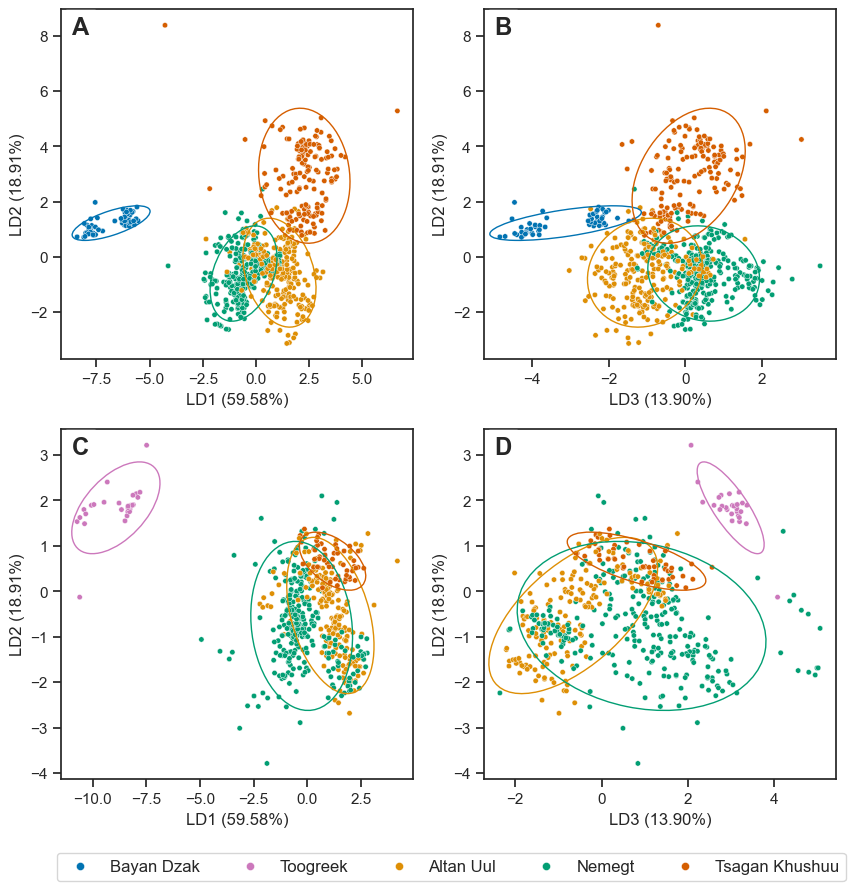

In [70]:
sns.set_theme(context='notebook', palette='dark', style='ticks')

order_locs_1 = ['Bayan Dzak', 'Altan Uul', 'Nemegt', 'Tsagan Khushuu']
order_locs_2 = ['Toogreek', 'Altan Uul', 'Nemegt', 'Tsagan Khushuu']

dark_palette1 = np.array(sns.color_palette('colorblind'))[0:4].tolist()
dark_palette2 = np.array(sns.color_palette('colorblind'))[[4, 1, 2, 3]].tolist()

tick_labels = {
    'LDA1' : 'LD1 (59.58%)', 
    'LDA2' : 'LD2 (18.91%)', 
    'LDA3' : 'LD3 (13.90%)'
}

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax00 = sns.scatterplot(long_bones, x='LDA1', y='LDA2', hue='Locality', s=15, ax=ax[0, 0], hue_order=order_locs_1, palette=dark_palette1)
ellipses_95_confidence('LDA1', 'LDA2', long_bones, 'Locality', dark_palette1, group_order=order_locs_1, ax=ax00)
ax00.set_xlabel(tick_labels['LDA1'])
ax00.set_ylabel(tick_labels['LDA2'])
ax00.legend().set_visible(False)

ax01 = sns.scatterplot(long_bones, x='LDA3', y='LDA2', hue='Locality', s=15, ax=ax[0, 1], hue_order=order_locs_1, legend=False, palette=dark_palette1)
ellipses_95_confidence('LDA3', 'LDA2', long_bones, 'Locality', dark_palette1, group_order=order_locs_1, ax=ax[0,1])
ax01.set_xlabel(tick_labels['LDA3'])
ax01.set_ylabel(tick_labels['LDA2'])

ax10 = sns.scatterplot(trab_bones, x='LDA1', y='LDA2', hue='Locality', s=15, ax=ax[1, 0], hue_order=order_locs_2, palette=dark_palette2)
ellipses_95_confidence('LDA1', 'LDA2', trab_bones, 'Locality', dark_palette2, group_order=order_locs_2, ax=ax[1,0])
ax10.set_xlabel(tick_labels['LDA1'])
ax10.set_ylabel(tick_labels['LDA2'])
ax10.legend().set_visible(False)

ax11 = sns.scatterplot(trab_bones, x='LDA3', y='LDA2', hue='Locality', s=15, ax=ax[1, 1], hue_order=order_locs_2, legend=False, palette=dark_palette2)
ellipses_95_confidence('LDA3', 'LDA2', trab_bones, 'Locality', dark_palette2, group_order=order_locs_2, ax=ax[1,1])
ax11.set_xlabel(tick_labels['LDA3'])
ax11.set_ylabel(tick_labels['LDA2'])

handAB, labAB = ax00.get_legend_handles_labels()
handCD, labCD = ax10.get_legend_handles_labels()

handles = [handAB[0]] + handCD
labels = [labAB[0]] + labCD

fig.legend(handles, labels, fontsize='medium', title_fontsize='x-large', loc='lower center', markerscale=1.5, ncols=5, bbox_to_anchor=(0.515, 0.0))

for num, axs in zip(["A", "B", "C", "D"], ax.flat):
    axs.text(0.03, 0.93, str(num), transform=axs.transAxes, bbox=dict(facecolor='white'), fontsize='x-large', fontweight='bold')

fig.savefig('Plots/LDA separation.png', dpi=300, bbox_inches='tight')

---

## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
logreg = LogisticRegression(class_weight='balanced')

In [75]:
logreg.fit(lb1_train, locs_lb1_train)

LogisticRegression(class_weight='balanced')

In [76]:
locs_pred = logreg.predict(lb1_test)

In [77]:
acc_meas(locs_lb1_test, locs_pred)

accuracy score:    0.5
f1 weighted score: 0.5002953464539556
f1 micro score:    0.5


In [78]:
prediction_accuracy_frame(locs_lb1_test, locs_pred)

Locality PredictionMode  PredictionAccuracy
SampleID Line                                                   
PR006    L1        Bayan Dzak     Bayan Dzak            1.000000
         L2        Bayan Dzak     Bayan Dzak            1.000000
         L3        Bayan Dzak     Bayan Dzak            1.000000
TS012    L1         Altan Uul      Altan Uul            1.000000
TS020    L1            Nemegt         Nemegt            0.976744
TS021    L1         Altan Uul         Nemegt            0.171429
TS022    L1         Altan Uul         Nemegt            0.000000
         L2         Altan Uul         Nemegt            0.058824
TS029    L1            Nemegt      Altan Uul            0.150943
TS030    L1    Tsagan Khushuu      Altan Uul            0.461538
         L2    Tsagan Khushuu      Altan Uul            0.000000

### Logistic Regression - LB1 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [81]:
lr_params = {
    'C' : [0.01, 0.1, 1., 10], #np.logspace(-2, 2, 7),
    'multi_class' : ['ovr', 'multinomial'],
    'solver' : ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag', 'newton-cholesky']
}

In [82]:
logreg_grid = GridSearchCV(LogisticRegression(random_state=13, class_weight='balanced'), param_grid=lr_params, cv=3, n_jobs=-1)

In [83]:
logreg_grid.fit(lb1_train, locs_lb1_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=13),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'multi_class': ['ovr', 'multinomial'],
                         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg',
                                    'sag', 'newton-cholesky']})

In [84]:
sorted_grid_logreg = grid_results_view(logreg_grid)

In [85]:
sorted_grid_logreg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,0.047559,0.003258,0.003508,4.083525e-04,10.00,ovr,newton-cholesky,"{'C': 10, 'multi_class': 'ovr', 'solver': 'new...",0.728205,0.953608,0.984536,0.888783,0.114246,1
39,0.097737,0.021413,0.002666,4.704162e-04,10.00,ovr,newton-cg,"{'C': 10, 'multi_class': 'ovr', 'solver': 'new...",0.728205,0.953608,0.984536,0.888783,0.114246,1
36,0.015670,0.002868,0.003001,5.619580e-07,10.00,ovr,liblinear,"{'C': 10, 'multi_class': 'ovr', 'solver': 'lib...",0.728205,0.943299,0.984536,0.885347,0.112384,3
29,0.045230,0.006433,0.004668,1.700142e-03,1.00,ovr,newton-cholesky,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'ne...",0.728205,0.927835,0.963918,0.873319,0.103663,4
27,0.083440,0.018211,0.002667,9.420664e-04,1.00,ovr,newton-cg,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'ne...",0.728205,0.927835,0.963918,0.873319,0.103663,4
38,0.137475,0.026208,0.002667,4.722150e-04,10.00,ovr,lbfgs,"{'C': 10, 'multi_class': 'ovr', 'solver': 'lbf...",0.728205,0.902062,0.984536,0.871601,0.106840,6
24,0.018004,0.004900,0.002667,4.705275e-04,1.00,ovr,liblinear,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'li...",0.728205,0.917526,0.953608,0.866446,0.098855,7
26,0.091444,0.011815,0.003001,2.081521e-06,1.00,ovr,lbfgs,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'lb...",0.728205,0.896907,0.974227,0.866446,0.102722,7
44,0.098011,0.014726,0.003669,9.426848e-04,10.00,multinomial,lbfgs,"{'C': 10, 'multi_class': 'multinomial', 'solve...",0.728205,0.871134,0.948454,0.849264,0.091236,9
12,0.018514,0.004278,0.003665,9.444912e-04,0.10,ovr,liblinear,"{'C': 0.1, 'multi_class': 'ovr', 'solver': 'li...",0.723077,0.896907,0.912371,0.844118,0.085822,10


In [86]:
logreg_lb1_bparams = sorted_grid_logreg.iloc[0]['params']

### Logistic Regression - LB1 - Best Params

Fitted model

In [89]:
logreg_lb1_best = LogisticRegression(**logreg_lb1_bparams, random_state=13, class_weight='balanced') #, class_weight='balanced')

In [90]:
logreg_lb1_best.fit(lb1_train, locs_lb1_train)

LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   random_state=13, solver='newton-cholesky')

Prediction and accuracy measures

In [92]:
# locs_pred = logreg.predict(lb1_test)
locs_pred = logreg_lb1_best.predict(lb1_test)

In [93]:
logreg_acc = acc_meas(locs_lb1_test, locs_pred, return_vals=True)

accuracy score:    0.4557823129251701
f1 weighted score: 0.45766530943432254
f1 micro score:    0.4557823129251701


Prediction for the spots in the whole sample

In [95]:
logreg_predframe = prediction_accuracy_frame(locs_lb1_test, locs_pred)
display(logreg_predframe)

Locality PredictionMode  PredictionAccuracy
SampleID Line                                                   
PR006    L1        Bayan Dzak     Bayan Dzak            1.000000
         L2        Bayan Dzak     Bayan Dzak            1.000000
         L3        Bayan Dzak     Bayan Dzak            1.000000
TS012    L1         Altan Uul      Altan Uul            1.000000
TS020    L1            Nemegt         Nemegt            0.976744
TS021    L1         Altan Uul         Nemegt            0.085714
TS022    L1         Altan Uul         Nemegt            0.000000
         L2         Altan Uul         Nemegt            0.000000
TS029    L1            Nemegt      Altan Uul            0.000000
TS030    L1    Tsagan Khushuu      Altan Uul            0.442308
         L2    Tsagan Khushuu      Altan Uul            0.000000

Add the data to the confusion matrices dictionary

In [97]:
conf_mat_dict['logreg']['lb1'] = {'conf_mat' : confusion_matrix(locs_lb1_test, locs_pred, normalize='true', labels=lb_label_order), 'labels' : lb_label_acronym}

---

### Logistic Regression - LB2 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [101]:
lr_params = {
    'C' : [0.01, 0.1, 1., 10], #np.logspace(-2, 2, 7),
    'multi_class' : ['ovr', 'multinomial'],
    'solver' : ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag', 'newton-cholesky']
}

In [102]:
logreg_grid = GridSearchCV(LogisticRegression(random_state=13, class_weight='balanced'), param_grid=lr_params, cv=3, n_jobs=-1)

In [103]:
logreg_grid.fit(lb2_train, locs_lb2_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=13),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'multi_class': ['ovr', 'multinomial'],
                         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg',
                                    'sag', 'newton-cholesky']})

In [104]:
sorted_grid_logreg = grid_results_view(logreg_grid)

In [105]:
sorted_grid_logreg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
38,0.087539,0.003267,0.003001,1.189441e-06,10.00,ovr,lbfgs,"{'C': 10, 'multi_class': 'ovr', 'solver': 'lbf...",0.682635,0.922156,0.891566,0.832119,0.106436,1
39,0.096366,0.028187,0.003001,1.011524e-06,10.00,ovr,newton-cg,"{'C': 10, 'multi_class': 'ovr', 'solver': 'new...",0.682635,0.940120,0.873494,0.832083,0.109120,2
26,0.090718,0.006111,0.002668,4.719323e-04,1.00,ovr,lbfgs,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'lb...",0.682635,0.928144,0.879518,0.830099,0.106146,3
41,0.041182,0.003074,0.003001,1.168008e-06,10.00,ovr,newton-cholesky,"{'C': 10, 'multi_class': 'ovr', 'solver': 'new...",0.682635,0.940120,0.867470,0.830075,0.108393,4
36,0.016690,0.004163,0.003335,4.722134e-04,10.00,ovr,liblinear,"{'C': 10, 'multi_class': 'ovr', 'solver': 'lib...",0.682635,0.916168,0.867470,0.822091,0.100594,5
29,0.038367,0.003686,0.002333,4.723262e-04,1.00,ovr,newton-cholesky,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'ne...",0.682635,0.928144,0.855422,0.822067,0.102966,6
27,0.080732,0.008717,0.003001,8.167300e-04,1.00,ovr,newton-cg,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'ne...",0.682635,0.928144,0.855422,0.822067,0.102966,6
24,0.012001,0.000816,0.002334,4.714302e-04,1.00,ovr,liblinear,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'li...",0.682635,0.916168,0.849398,0.816067,0.098209,8
45,0.074369,0.013787,0.002001,5.947204e-07,10.00,multinomial,newton-cg,"{'C': 10, 'multi_class': 'multinomial', 'solve...",0.682635,0.940120,0.819277,0.814011,0.105184,9
33,0.097756,0.027389,0.003329,4.640653e-04,1.00,multinomial,newton-cg,"{'C': 1.0, 'multi_class': 'multinomial', 'solv...",0.682635,0.934132,0.801205,0.805990,0.102729,10


In [106]:
logreg_lb2_bparams = sorted_grid_logreg.iloc[0]['params']

### Logistic Regression - LB2 - Best Params

Fitted model

In [109]:
logreg_lb2_best = LogisticRegression(**logreg_lb2_bparams, random_state=13, class_weight='balanced') #, class_weight='balanced')

In [110]:
logreg_lb2_best.fit(lb2_train, locs_lb2_train)

LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   random_state=13)

Prediction and accuracy measures

In [112]:
locs_pred = logreg_lb2_best.predict(lb2_test)

In [113]:
logreg_acc = acc_meas(locs_lb2_test, locs_pred, return_vals=True)

accuracy score:    0.5095785440613027
f1 weighted score: 0.5085765400955894
f1 micro score:    0.5095785440613027


Prediction for the spots in the whole sample

In [115]:
logreg_predframe = prediction_accuracy_frame(locs_lb2_test, locs_pred)
display(logreg_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            1.000000
         L2        Bayan Dzak      Bayan Dzak            1.000000
         L3        Bayan Dzak      Bayan Dzak            1.000000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul          Nemegt            0.142857
TS029    L1            Nemegt  Tsagan Khushuu            0.018868
TS030    L1    Tsagan Khushuu       Altan Uul            0.384615
         L2    Tsagan Khushuu       Altan Uul            0.000000

In [116]:
lb2_results['Predict_logreg'] = lb2_results['Locality'] == locs_pred

Add the data to the confusion matrices dictionary

In [118]:
conf_mat_dict['logreg']['lb2'] = {'conf_mat' : confusion_matrix(locs_lb2_test, locs_pred, normalize='true', labels=lb_label_order), 'labels' : lb_label_acronym}

---

### Logistic Regression - TB - Hyperparameters

In [121]:
lr_params = {
    'C' : [0.01, 0.1, 1., 10], #np.logspace(-2, 2, 7),
    'multi_class' : ['ovr', 'multinomial'],
    'solver' : ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag', 'newton-cholesky']
}

In [122]:
logreg_grid = GridSearchCV(LogisticRegression(random_state=13, class_weight='balanced'), param_grid=lr_params, cv=3, n_jobs=-1)

In [123]:
logreg_grid.fit(tb_train, locs_tb_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=13),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'multi_class': ['ovr', 'multinomial'],
                         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg',
                                    'sag', 'newton-cholesky']})

In [124]:
sorted_grid_logreg = grid_results_view(logreg_grid)

In [125]:
sorted_grid_logreg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
46,0.016914,0.001699,0.002001,1.140650e-06,10.00,multinomial,sag,"{'C': 10, 'multi_class': 'multinomial', 'solve...",0.976471,0.988095,0.892857,0.952474,0.042422,1
1,0.037676,0.008058,0.005336,2.056616e-03,0.01,ovr,saga,"{'C': 0.01, 'multi_class': 'ovr', 'solver': 's...",0.976471,1.000000,0.880952,0.952474,0.051478,1
40,0.045010,0.000816,0.004334,4.714282e-04,10.00,ovr,sag,"{'C': 10, 'multi_class': 'ovr', 'solver': 'sag'}",0.976471,1.000000,0.880952,0.952474,0.051478,1
4,0.028670,0.000945,0.003083,1.162129e-04,0.01,ovr,sag,"{'C': 0.01, 'multi_class': 'ovr', 'solver': 's...",0.976471,1.000000,0.880952,0.952474,0.051478,1
37,0.044936,0.004322,0.002999,2.153113e-06,10.00,ovr,saga,"{'C': 10, 'multi_class': 'ovr', 'solver': 'saga'}",0.976471,1.000000,0.880952,0.952474,0.051478,1
34,0.021671,0.001886,0.003003,9.199649e-07,1.00,multinomial,sag,"{'C': 1.0, 'multi_class': 'multinomial', 'solv...",0.976471,0.988095,0.892857,0.952474,0.042422,1
28,0.047010,0.005718,0.003668,4.742380e-04,1.00,ovr,sag,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'sag'}",0.976471,1.000000,0.880952,0.952474,0.051478,1
26,0.077328,0.000980,0.003001,8.172176e-04,1.00,ovr,lbfgs,"{'C': 1.0, 'multi_class': 'ovr', 'solver': 'lb...",0.976471,0.988095,0.892857,0.952474,0.042422,1
12,0.011003,0.000816,0.002668,4.708086e-04,0.10,ovr,liblinear,"{'C': 0.1, 'multi_class': 'ovr', 'solver': 'li...",0.976471,1.000000,0.880952,0.952474,0.051478,1
13,0.048821,0.001405,0.004189,1.995688e-03,0.10,ovr,saga,"{'C': 0.1, 'multi_class': 'ovr', 'solver': 'sa...",0.976471,1.000000,0.880952,0.952474,0.051478,1


In [126]:
logreg_tb_bparams = sorted_grid_logreg.iloc[0]['params']

### Logistic Regression - TB - Best Params

Fitted model

In [129]:
logreg_tb = LogisticRegression(class_weight='balanced', random_state=13, **logreg_tb_bparams)
logreg_tb.fit(tb_train, locs_tb_train)

LogisticRegression(C=10, class_weight='balanced', multi_class='multinomial',
                   random_state=13, solver='sag')

Prediction and accuracy measures

In [131]:
locs_tb_pred = logreg_tb.predict(tb_test)

In [132]:
logreg_acc = acc_meas(locs_tb_test, locs_tb_pred, return_vals=True)

accuracy score:    0.5123456790123457
f1 weighted score: 0.4802719262691657
f1 micro score:    0.5123456790123457


Prediction for the spots in the whole sample

In [134]:
logreg_tb_predframe = prediction_accuracy_frame(locs_tb_test, locs_tb_pred)
display(logreg_tb_predframe)

Locality       PredictionMode  PredictionAccuracy
SampleID Line                                                         
PR001    L1          Toogreek             Toogreek              1.0000
SF003    L1         Altan Uul  [Altan Uul, Nemegt]              0.5000
         L2         Altan Uul            Altan Uul              1.0000
         L3         Altan Uul            Altan Uul              1.0000
         L4         Altan Uul            Altan Uul              0.6000
TF028    L1            Nemegt               Nemegt              1.0000
         L2            Nemegt               Nemegt              0.9375
         L3            Nemegt            Altan Uul              0.0000
         L4            Nemegt            Altan Uul              0.0000
TS027    L1    Tsagan Khushuu            Altan Uul              0.0000
         L2    Tsagan Khushuu               Nemegt              0.0000
         L3    Tsagan Khushuu            Altan Uul              0.0000

Add the data to the confusion matrices dictionary

In [136]:
conf_mat_dict['logreg']['tb'] = {'conf_mat' : confusion_matrix(locs_tb_test, locs_tb_pred, normalize='true', labels=tb_label_order), 'labels' : tb_label_acronym}

---

## Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
forest = RandomForestClassifier(criterion="entropy", class_weight='balanced')

In [141]:
forest.fit(lb1_train, locs_lb1_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy')

In [142]:
locs_pred = forest.predict(lb1_test)

In [143]:
acc_meas(locs_lb1_test, locs_pred)

accuracy score:    0.6870748299319728
f1 weighted score: 0.6790726461103265
f1 micro score:    0.6870748299319728


In [144]:
prediction_accuracy_frame(locs_lb1_test, locs_pred)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            0.700000
         L2        Bayan Dzak      Bayan Dzak            0.888889
         L3        Bayan Dzak      Bayan Dzak            0.750000
TS012    L1         Altan Uul       Altan Uul            1.000000
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul          Nemegt            0.085714
TS022    L1         Altan Uul          Nemegt            0.187500
         L2         Altan Uul          Nemegt            0.176471
TS029    L1            Nemegt          Nemegt            0.754717
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.750000
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

### Random Forest - LB1 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [147]:
forest_params = {
    'criterion' : ['log_loss'],
    'n_estimators' : [100, 150],
    'max_depth' : [5, 6],
    'min_samples_leaf' : [1, 2],
    'max_features' : [None, 'log2', 'sqrt']
}

In [148]:
forest_const_params = {
    'random_state' : 13,
    'warm_start' : True,
    'class_weight' : 'balanced'
}

In [149]:
forest_grid = GridSearchCV(estimator=RandomForestClassifier(**forest_const_params), param_grid=forest_params, cv=3, n_jobs=-1)

In [150]:
forest_grid.fit(lb1_train, locs_lb1_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=13,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'criterion': ['log_loss'], 'max_depth': [5, 6],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 150]})

In [151]:
sorted_grid_forest = grid_results_view(forest_grid)

In [152]:
sorted_grid_forest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,0.319616,0.060893,0.009518,0.000007,log_loss,5,log2,2,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.707692,0.958763,1.0,0.888818,0.129177,1
18,0.318453,0.018084,0.009678,0.000479,log_loss,6,log2,2,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.707692,0.953608,1.0,0.887100,0.128266,2
4,0.305147,0.007774,0.009336,0.001248,log_loss,5,log2,1,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.707692,0.943299,1.0,0.883664,0.126565,3
21,0.489360,0.013933,0.007836,0.000625,log_loss,6,sqrt,1,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.723077,0.922680,1.0,0.881919,0.116670,4
19,0.478823,0.028061,0.011679,0.002327,log_loss,6,log2,2,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.712821,0.927835,1.0,0.880219,0.121980,5
11,0.506851,0.021722,0.013505,0.001078,log_loss,5,sqrt,2,150,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.723077,0.912371,1.0,0.878483,0.115565,6
20,0.350387,0.021183,0.010011,0.000409,log_loss,6,sqrt,1,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.723077,0.912371,1.0,0.878483,0.115565,6
7,0.504296,0.036518,0.014012,0.001876,log_loss,5,log2,2,150,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.712821,0.917526,1.0,0.876782,0.120728,8
17,0.480880,0.037438,0.012508,0.000407,log_loss,6,log2,1,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.712821,0.917526,1.0,0.876782,0.120728,8
8,0.353501,0.035553,0.010677,0.000626,log_loss,5,sqrt,1,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.723077,0.907216,1.0,0.876764,0.115086,10


**Best parameters** for the algorithm

In [154]:
forest_lb1_bparams = sorted_grid_forest.iloc[0]['params']

### Random Forest - LB1 - Best Params

Fitted model

In [157]:
forest_lb1_best = RandomForestClassifier(**forest_lb1_bparams, **forest_const_params)

In [158]:
forest_lb1_best.fit(lb1_train, locs_lb1_train)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=5, max_features='log2', min_samples_leaf=2,
                       random_state=13, warm_start=True)

Prediction and accuracy measures

In [160]:
locs_pred = forest_lb1_best.predict(lb1_test)

In [161]:
forest_acc = acc_meas(locs_lb1_test, locs_pred, return_vals=True)

accuracy score:    0.717687074829932
f1 weighted score: 0.7061478443887484
f1 micro score:    0.717687074829932


Prediction for the spots in the whole sample

In [163]:
forest_predframe = prediction_accuracy_frame(locs_lb1_test, locs_pred)
display(forest_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            0.800000
         L2        Bayan Dzak      Bayan Dzak            1.000000
         L3        Bayan Dzak      Bayan Dzak            0.875000
TS012    L1         Altan Uul       Altan Uul            0.923077
TS020    L1            Nemegt          Nemegt            1.000000
TS021    L1         Altan Uul          Nemegt            0.171429
TS022    L1         Altan Uul          Nemegt            0.187500
         L2         Altan Uul          Nemegt            0.058824
TS029    L1            Nemegt          Nemegt            0.660377
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.980769
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

In [164]:
forest_predframe.groupby('Locality')['PredictionAccuracy'].mean()

Locality
Altan Uul         0.335207
Bayan Dzak        0.891667
Nemegt            0.830189
Tsagan Khushuu    0.990385
Name: PredictionAccuracy, dtype: float64

Add the data to the confusion matrices dictionary

In [166]:
conf_mat_dict['forest']['lb1'] = {'conf_mat' : confusion_matrix(locs_lb1_test, locs_pred, normalize='true', labels=lb_label_order), 'labels' : lb_label_acronym}

---

### Random Forest - LB2 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [170]:
forest_params = {
    'criterion' : ['log_loss'],
    'n_estimators' : [100, 150],
    'max_depth' : [5, 6],
    'min_samples_leaf' : [1, 2],
    'max_features' : [None, 'log2', 'sqrt']
}

In [171]:
forest_const_params = {
    'random_state' : 13,
    'warm_start' : True,
    'class_weight' : 'balanced'
}

In [172]:
forest_grid = GridSearchCV(estimator=RandomForestClassifier(**forest_const_params), param_grid=forest_params, cv=3, n_jobs=-1)

In [173]:
forest_grid.fit(lb2_train, locs_lb2_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=13,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'criterion': ['log_loss'], 'max_depth': [5, 6],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 150]})

In [174]:
sorted_grid_forest = grid_results_view(forest_grid)

In [175]:
sorted_grid_forest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,0.464525,0.016666,0.009507,0.001777,log_loss,6,sqrt,1,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.688623,0.988024,0.903614,0.860087,0.126046,1
23,0.333283,0.004487,0.008009,0.000405,log_loss,6,sqrt,2,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.682635,0.988024,0.897590,0.856083,0.128083,2
9,0.468537,0.039123,0.012846,0.001539,log_loss,5,sqrt,1,150,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.688623,0.964072,0.909639,0.854111,0.119109,3
11,0.479409,0.022644,0.012169,0.000240,log_loss,5,sqrt,2,150,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.682635,0.958084,0.915663,0.852127,0.121094,4
22,0.319668,0.002017,0.008152,0.000970,log_loss,6,sqrt,2,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.676647,0.982036,0.879518,0.846067,0.126899,5
20,0.352252,0.022145,0.009852,0.000941,log_loss,6,sqrt,1,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.688623,0.982036,0.867470,0.846043,0.120740,6
8,0.311399,0.011267,0.010174,0.000245,log_loss,5,sqrt,1,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.682635,0.964072,0.861446,0.836051,0.116291,7
16,0.315797,0.030109,0.010514,0.001088,log_loss,6,log2,1,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.664671,0.958084,0.861446,0.828067,0.122089,8
10,0.311415,0.012540,0.012357,0.002319,log_loss,5,sqrt,2,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.670659,0.946108,0.861446,0.826071,0.115200,9
17,0.456196,0.046022,0.013527,0.001081,log_loss,6,log2,1,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.664671,0.958084,0.855422,0.826059,0.121572,10


In [176]:
forest_lb2_bparams = sorted_grid_forest.iloc[0]['params']

### Random Forest - LB2 - Best Params

Fitted model

In [179]:
forest_lb2_best = RandomForestClassifier(**forest_lb2_bparams, **forest_const_params)

In [180]:
forest_lb2_best.fit(lb2_train, locs_lb2_train)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, n_estimators=150, random_state=13,
                       warm_start=True)

Prediction and accuracy measures

In [182]:
locs_pred = forest_lb2_best.predict(lb2_test)

In [183]:
forest_acc = acc_meas(locs_lb2_test, locs_pred, return_vals=True)

accuracy score:    0.8122605363984674
f1 weighted score: 0.8129099446097544
f1 micro score:    0.8122605363984674


Prediction for the spots in the whole sample

In [185]:
forest_predframe = prediction_accuracy_frame(locs_lb2_test, locs_pred)
display(forest_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            0.800000
         L2        Bayan Dzak      Bayan Dzak            1.000000
         L3        Bayan Dzak      Bayan Dzak            0.875000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul          Nemegt            0.400000
TS029    L1            Nemegt          Nemegt            0.698113
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.865385
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

In [186]:
forest_predframe.groupby('Locality')['PredictionAccuracy'].mean()

Locality
Altan Uul         0.687179
Bayan Dzak        0.891667
Nemegt            0.837429
Tsagan Khushuu    0.932692
Name: PredictionAccuracy, dtype: float64

In [187]:
lb2_results['Predict_forest'] = lb2_results['Locality'] == locs_pred

Add the data to the confusion matrices dictionary

In [189]:
conf_mat_dict['forest']['lb2'] = {'conf_mat' : confusion_matrix(locs_lb2_test, locs_pred, normalize='true', labels=lb_label_order), 'labels' : lb_label_acronym}

---

### Random Forest - TB - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [193]:
forest_params = {
    'criterion' : ['gini'],
    'n_estimators' : [50, 100, 150],
    'max_depth' : [5, 6],
    'min_samples_leaf' : [1, 2],
    'max_features' : [None, 'log2', 'sqrt']
}

In [194]:
forest_const_params = {
    'random_state' : 13,
    'warm_start' : True,
    'class_weight' : 'balanced'
}

In [195]:
forest_tb_grid = GridSearchCV(estimator=RandomForestClassifier(**forest_const_params), param_grid=forest_params, cv=3, n_jobs=-1)

In [196]:
forest_tb_grid.fit(tb_train, locs_tb_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=13,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 6],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 150]})

In [197]:
sorted_tb_grid_forest = grid_results_view(forest_tb_grid)

In [198]:
forest_tb_bparams = sorted_grid_forest.iloc[0]['params']

### Random Forest - TB - Best Params

Fitted model

In [201]:
forest_tb_best = RandomForestClassifier(**forest_tb_bparams, **forest_const_params)

In [202]:
forest_tb_best.fit(tb_train, locs_tb_train)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, n_estimators=150, random_state=13,
                       warm_start=True)

Prediction and accuracy measures

In [204]:
locs_tb_pred = forest_tb_best.predict(tb_test)

In [205]:
forest_acc = acc_meas(locs_tb_test, locs_tb_pred, return_vals=True)

accuracy score:    0.30864197530864196
f1 weighted score: 0.3281121399176955
f1 micro score:    0.30864197530864196


Prediction for the spots in the whole sample

In [207]:
forest_predframe = prediction_accuracy_frame(locs_tb_test, locs_tb_pred)
display(forest_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR001    L1          Toogreek        Toogreek            1.000000
SF003    L1         Altan Uul          Nemegt            0.000000
         L2         Altan Uul  Tsagan Khushuu            0.066667
         L3         Altan Uul  Tsagan Khushuu            0.076923
         L4         Altan Uul          Nemegt            0.000000
TF028    L1            Nemegt          Nemegt            1.000000
         L2            Nemegt          Nemegt            1.000000
         L3            Nemegt       Altan Uul            0.033333
         L4            Nemegt       Altan Uul            0.045455
TS027    L1    Tsagan Khushuu          Nemegt            0.000000
         L2    Tsagan Khushuu          Nemegt            0.000000
         L3    Tsagan Khushuu          Nemegt            0.000000

Add the data to the confusion matrices dictionary

In [209]:
conf_mat_dict['forest']['tb'] = {'conf_mat' : confusion_matrix(locs_tb_test, locs_tb_pred, normalize='true', labels=tb_label_order), 'labels' : tb_label_acronym}

---

## XGBoost

In [212]:
from xgboost import XGBClassifier

In [213]:
loc2num = {name : num for num, name in enumerate(lb_label_order)}
num2loc = {num : name for num, name in enumerate(lb_label_order)}

In [214]:
locs_lb1_train_num = locs_lb1_train.replace(loc2num)
locs_lb1_test_num = locs_lb1_test.replace(loc2num)

In [215]:
locs_lb2_train_num = locs_lb2_train.replace(loc2num)
locs_lb2_test_num = locs_lb2_test.replace(loc2num)

In [216]:
xgb = XGBClassifier(n_estimators=100, random_state=13, enable_categorical=True)

In [217]:
xgb.fit(lb1_train, locs_lb1_train_num)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [218]:
locs_pred, acc_score, predframe = model_predictions(xgb, lb1_test, locs_lb1_test_num)

In [219]:
predframe.explode('PredictionMode').replace({'Locality' : num2loc, 'PredictionMode' : num2loc})

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.000000
         L2        Bayan Dzak          Nemegt            0.000000
         L3        Bayan Dzak          Nemegt            0.000000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul       Altan Uul            0.857143
TS022    L1         Altan Uul          Nemegt            0.062500
         L2         Altan Uul          Nemegt            0.000000
TS029    L1            Nemegt          Nemegt            0.962264
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.807692
         L2    Tsagan Khushuu  Tsagan Khushuu            0.583333

### XGB - LB1 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [222]:
xgb_params = {
    'n_estimators' : [75, 100],
    'max_depth' : [3, 5],
    'max_leaves' : [2, 4],
    'tree_method' : ['hist'],
    'learning_rate' : [0.1, 0.2, 0.7, 0.9]
}

In [223]:
xgb_const = {
    'abooster' : 'gblinear',
    'random_stae' : 13
}

In [224]:
xgb_grid = GridSearchCV(XGBClassifier(**xgb_const), param_grid=xgb_params, cv=3, n_jobs=-1)

In [225]:
xgb_grid.fit(lb1_train, locs_lb1_train_num)

GridSearchCV(cv=3,
             estimator=XGBClassifier(abooster='gblinear', base_score=None,
                                     booster=None, callbacks=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.7, 0.9],
                         'max_depth': [3, 5], 'max_leaves': [2, 4],
                         'n_estimators': [75, 100], 'tree_method': ['hist']})

In [226]:
sorted_grid_xboost = grid_results_view(xgb_grid)

In [227]:
sorted_grid_xboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_leaves,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
31,0.096765,0.031816,0.006838,0.000233,0.9,5,4,100,hist,"{'learning_rate': 0.9, 'max_depth': 5, 'max_le...",0.697436,0.994845,0.994845,0.895709,0.140200,1
27,0.137472,0.035917,0.007851,0.001028,0.9,3,4,100,hist,"{'learning_rate': 0.9, 'max_depth': 3, 'max_le...",0.697436,0.994845,0.994845,0.895709,0.140200,1
23,0.163877,0.030679,0.010852,0.001856,0.7,5,4,100,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.697436,0.989691,1.000000,0.895709,0.140263,1
19,0.169981,0.033046,0.014019,0.001461,0.7,3,4,100,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.697436,0.989691,1.000000,0.895709,0.140263,1
26,0.134134,0.024552,0.010506,0.002487,0.9,3,4,75,hist,"{'learning_rate': 0.9, 'max_depth': 3, 'max_le...",0.697436,0.989691,0.994845,0.893991,0.139001,5
22,0.144053,0.028173,0.013511,0.000409,0.7,5,4,75,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.697436,0.989691,0.994845,0.893991,0.139001,5
18,0.141620,0.027953,0.014029,0.000409,0.7,3,4,75,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.697436,0.989691,0.994845,0.893991,0.139001,5
30,0.101120,0.011267,0.008679,0.002349,0.9,5,4,75,hist,"{'learning_rate': 0.9, 'max_depth': 5, 'max_le...",0.697436,0.989691,0.994845,0.893991,0.139001,5
11,0.243736,0.051559,0.014857,0.001670,0.2,3,4,100,hist,"{'learning_rate': 0.2, 'max_depth': 3, 'max_le...",0.702564,0.989691,0.989691,0.893982,0.135353,9
15,0.231703,0.044929,0.014842,0.001832,0.2,5,4,100,hist,"{'learning_rate': 0.2, 'max_depth': 5, 'max_le...",0.702564,0.989691,0.989691,0.893982,0.135353,9


In [228]:
xboost_lb1_bparams = sorted_grid_xboost.iloc[0]['params']

### XGB - LB1 - Best Params

Fitted model

In [231]:
xboost_lb1_best = XGBClassifier(**xboost_lb1_bparams, **xgb_const)

In [232]:
xboost_lb1_best.fit(lb1_train, locs_lb1_train_num)

XGBClassifier(abooster='gblinear', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Prediction and accuracy measures

In [234]:
locs_pred, acc_score, predframe = model_predictions(xboost_lb1_best, lb1_test, locs_lb1_test_num)

In [235]:
locs_pred_names = pd.Series(locs_pred).replace(num2loc)

In [236]:
acc_meas(locs_lb1_test, locs_pred_names)

accuracy score:    0.5952380952380952
f1 weighted score: 0.57206972786074
f1 micro score:    0.5952380952380952


Prediction for the spots in the whole sample

In [238]:
xboost_predframe = predframe.explode('PredictionMode').replace({'Locality' : num2loc, 'PredictionMode' : num2loc})
display(xboost_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.000000
         L2        Bayan Dzak          Nemegt            0.000000
         L3        Bayan Dzak          Nemegt            0.000000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul       Altan Uul            0.828571
TS022    L1         Altan Uul          Nemegt            0.000000
         L2         Altan Uul          Nemegt            0.000000
TS029    L1            Nemegt          Nemegt            0.490566
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.692308
         L2    Tsagan Khushuu       Altan Uul            0.333333

Add the data to the confusion matrices dictionary

In [240]:
conf_mat_dict['xboost']['lb1'] = {'conf_mat' : confusion_matrix(locs_lb1_test_num, locs_pred, normalize='true'), 'labels' : [locdict[j] for j in [num2loc[i] for i in xboost_lb1_best.classes_]]}

---

### XGB - LB2 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [244]:
xgb_params = {
    'n_estimators' : [75, 100],
    'max_depth' : [3, 5],
    'max_leaves' : [2, 4],
    'tree_method' : ['hist'],
    'learning_rate' : [0.1, 0.2, 0.7, 0.9]
}

In [245]:
xgb_const = {
    'abooster' : 'gblinear',
    'random_stae' : 13
}

In [246]:
xgb_grid = GridSearchCV(XGBClassifier(**xgb_const), param_grid=xgb_params, cv=3, n_jobs=-1)

In [247]:
xgb_grid.fit(lb2_train, locs_lb2_train_num)

GridSearchCV(cv=3,
             estimator=XGBClassifier(abooster='gblinear', base_score=None,
                                     booster=None, callbacks=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.7, 0.9],
                         'max_depth': [3, 5], 'max_leaves': [2, 4],
                         'n_estimators': [75, 100], 'tree_method': ['hist']})

In [248]:
sorted_grid_xboost = grid_results_view(xgb_grid)

In [249]:
sorted_grid_xboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_leaves,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.165081,0.037322,0.009842,0.002019,0.7,5,4,100,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
22,0.151908,0.031406,0.013191,0.001175,0.7,5,4,75,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
19,0.175772,0.043922,0.012684,0.000848,0.7,3,4,100,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
18,0.145541,0.032532,0.012189,0.001332,0.7,3,4,75,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
15,0.230661,0.041742,0.012697,0.000853,0.2,5,4,100,hist,"{'learning_rate': 0.2, 'max_depth': 5, 'max_le...",0.652695,0.988024,0.993976,0.878231,0.159497,5
11,0.235672,0.045860,0.013191,0.000632,0.2,3,4,100,hist,"{'learning_rate': 0.2, 'max_depth': 3, 'max_le...",0.652695,0.988024,0.993976,0.878231,0.159497,5
10,0.205824,0.027461,0.017523,0.004312,0.2,3,4,75,hist,"{'learning_rate': 0.2, 'max_depth': 3, 'max_le...",0.652695,0.988024,0.987952,0.876223,0.158059,7
14,0.194591,0.035387,0.013187,0.001298,0.2,5,4,75,hist,"{'learning_rate': 0.2, 'max_depth': 5, 'max_le...",0.652695,0.988024,0.987952,0.876223,0.158059,7
20,0.108202,0.011175,0.012518,0.001410,0.7,5,2,75,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.640719,0.994012,0.981928,0.872219,0.163770,9
16,0.122477,0.018878,0.015200,0.001939,0.7,3,2,75,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.640719,0.994012,0.981928,0.872219,0.163770,9


In [250]:
xboost_lb2_bparams = sorted_grid_xboost.iloc[0]['params']

### XGB - LB2 - Best Params

Fitted model

In [253]:
xboost_lb2_best = XGBClassifier(**xboost_lb2_bparams, **xgb_const)

In [254]:
xboost_lb2_best.fit(lb2_train, locs_lb2_train_num)

XGBClassifier(abooster='gblinear', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Prediction and accuracy measures

In [256]:
locs_pred, acc_score, predframe = model_predictions(xboost_lb2_best, lb2_test, locs_lb2_test_num)

In [257]:
locs_pred_names = pd.Series(locs_pred).replace(num2loc)

In [258]:
acc_meas(locs_lb2_test, locs_pred_names)

accuracy score:    0.7662835249042146
f1 weighted score: 0.724001632047609
f1 micro score:    0.7662835249042146


Prediction for the spots in the whole sample

In [260]:
xboost_predframe = predframe.explode('PredictionMode').replace({'Locality' : num2loc, 'PredictionMode' : num2loc})
display(xboost_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.000000
         L2        Bayan Dzak          Nemegt            0.000000
         L3        Bayan Dzak          Nemegt            0.000000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul       Altan Uul            0.771429
TS029    L1            Nemegt          Nemegt            0.886792
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.750000
         L2    Tsagan Khushuu  Tsagan Khushuu            0.583333

In [261]:
pred_xgb = locs_lb2_test_num == locs_pred

In [262]:
lb2_results['Predict_xboost'] = lb2_results['Locality'] == locs_pred

Add the data to the confusion matrices dictionary

In [264]:
conf_mat_dict['xboost']['lb2'] = {'conf_mat' : confusion_matrix(locs_lb2_test_num, locs_pred, normalize='true'), 'labels' : [locdict[j] for j in [num2loc[i] for i in xboost_lb2_best.classes_]]}

---

### XGB - TB - Hyperparamterers

XGBoost accepts numeric classes only, therefore, the classes are changed to numeric values for `loc_tb_2num` dictionary. The second one (`num_tb_2loc` does the reverse operation)

In [268]:
loc_tb_2num = {name : num for num, name in enumerate(tb_label_order)}
num_tb_2loc = {num : name for num, name in enumerate(tb_label_order)}

In [269]:
locs_tb_train_num = locs_tb_train.replace(loc_tb_2num)
locs_tb_test_num = locs_tb_test.replace(loc_tb_2num)

Hyperparameters search for the algorithm and data subset

In [271]:
xgb_tb_params = {
    'n_estimators' : [75, 100],
    'max_depth' : [3, 5],
    'max_leaves' : [2, 4],
    'tree_method' : ['hist'],
    'learning_rate' : [0.1, 0.2, 0.7, 0.9]
}

In [272]:
xgb_tb_const = {
    'abooster' : 'gblinear',
    'random_stae' : 13
}

In [273]:
xgb_grid_tb = GridSearchCV(XGBClassifier(**xgb_tb_const), param_grid=xgb_tb_params, cv=3, n_jobs=-1)

In [274]:
xgb_grid_tb.fit(tb_train, locs_tb_train_num)

GridSearchCV(cv=3,
             estimator=XGBClassifier(abooster='gblinear', base_score=None,
                                     booster=None, callbacks=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.7, 0.9],
                         'max_depth': [3, 5], 'max_leaves': [2, 4],
                         'n_estimators': [75, 100], 'tree_method': ['hist']})

In [275]:
sorted_tb_grid_xboost = grid_results_view(xgb_grid_tb)

In [276]:
xboost_tb_bparams = sorted_tb_grid_xboost.iloc[0]['params']

### XGB - TB - Best Params

Fitted model

In [279]:
xboost_tb_best = XGBClassifier(**xboost_tb_bparams, **xgb_const)

In [280]:
xboost_tb_best.fit(tb_train, locs_tb_train_num)

XGBClassifier(abooster='gblinear', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, ...)

Prediction and accuracy measures

In [282]:
locs_tb_num_pred, acc_score, predframe = model_predictions(xboost_tb_best, tb_test, locs_tb_test_num)

In [283]:
acc_meas(locs_tb_test_num, locs_tb_num_pred)

accuracy score:    0.07407407407407407
f1 weighted score: 0.07213930348258707
f1 micro score:    0.07407407407407407


Prediction for the spots in the whole sample

In [285]:
xboost_tb_predframe = predframe.explode('PredictionMode').replace({'Locality' : num_tb_2loc, 'PredictionMode' : num_tb_2loc})
display(xboost_tb_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR001    L1          Toogreek        Toogreek            1.000000
SF003    L1         Altan Uul          Nemegt            0.000000
         L1         Altan Uul  Tsagan Khushuu            0.000000
         L2         Altan Uul  Tsagan Khushuu            0.066667
         L3         Altan Uul  Tsagan Khushuu            0.000000
         L4         Altan Uul  Tsagan Khushuu            0.000000
TF028    L1            Nemegt       Altan Uul            0.000000
         L2            Nemegt       Altan Uul            0.000000
         L3            Nemegt       Altan Uul            0.000000
         L4            Nemegt       Altan Uul            0.000000
TS027    L1    Tsagan Khushuu          Nemegt            0.000000
         L2    Tsagan Khushuu          Nemegt            0.000000
         L3    Tsagan Khushuu          Nemegt            0.000000

Add the data to the confusion matrices dictionary

In [287]:
conf_mat_dict['xboost']['tb'] = {'conf_mat' : confusion_matrix(locs_tb_test_num, locs_tb_num_pred, normalize='true'), 'labels' : [locdict[j] for j in [num_tb_2loc[i] for i in xboost_tb_best.classes_]]}

--- --- ---

## AdaBoost

In [290]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [291]:
aboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=13)

In [292]:
aboost.fit(lb1_train, locs_lb1_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=13)

In [293]:
locs_pred, acc_score, predframe = model_predictions(aboost, lb1_test, locs_lb1_test)

In [294]:
acc_meas(locs_lb1_test, locs_pred)

accuracy score:    0.6870748299319728
f1 weighted score: 0.6761105606447565
f1 micro score:    0.6870748299319728


In [295]:
predframe

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            1.000000
         L2        Bayan Dzak      Bayan Dzak            1.000000
         L3        Bayan Dzak      Bayan Dzak            1.000000
TS012    L1         Altan Uul       Altan Uul            0.769231
TS020    L1            Nemegt          Nemegt            0.511628
TS021    L1         Altan Uul       Altan Uul            0.514286
TS022    L1         Altan Uul          Nemegt            0.375000
         L2         Altan Uul          Nemegt            0.235294
TS029    L1            Nemegt          Nemegt            0.584906
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            1.000000
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

### AdaBoost - LB1 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [298]:
aboost_params = {
    'algorithm' : ['SAMME', 'SAMME.R'],
    'n_estimators' : [50, 75],
    'learning_rate' : [1.0, 2.0],
    'estimator' : [DecisionTreeClassifier(max_depth=2), 
                   DecisionTreeClassifier(max_depth=3),
                   DecisionTreeClassifier(max_depth=4)]
}

In [299]:
aboost_grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(), random_state=13), param_grid=aboost_params, cv=3, n_jobs=-1)

In [300]:
aboost_grid.fit(lb1_train, locs_lb1_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=13),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [DecisionTreeClassifier(max_depth=2),
                                       DecisionTreeClassifier(max_depth=3),
                                       DecisionTreeClassifier(max_depth=4)],
                         'learning_rate': [1.0, 2.0],
                         'n_estimators': [50, 75]})

In [301]:
sorted_grid_aboost = grid_results_view(aboost_grid)

In [302]:
sorted_grid_aboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_estimator,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.321224,0.213707,0.008357,0.003810,SAMME.R,DecisionTreeClassifier(max_depth=4),2.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,1.000000,1.000000,0.909402,0.128125,1
22,0.254768,0.172034,0.008002,0.003743,SAMME.R,DecisionTreeClassifier(max_depth=4),2.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.994845,1.000000,0.907683,0.126928,2
20,0.283339,0.181594,0.010506,0.005346,SAMME.R,DecisionTreeClassifier(max_depth=4),1.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.984536,1.000000,0.904247,0.124640,3
17,0.317208,0.226503,0.010882,0.007393,SAMME.R,DecisionTreeClassifier(max_depth=3),1.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.984536,1.000000,0.904247,0.124640,3
10,0.261343,0.177724,0.011676,0.007034,SAMME,DecisionTreeClassifier(max_depth=4),2.0,50,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.728205,0.984536,1.000000,0.904247,0.124640,3
21,0.368355,0.254108,0.008675,0.004010,SAMME.R,DecisionTreeClassifier(max_depth=4),1.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.979381,1.000000,0.902529,0.123553,6
19,0.301383,0.211453,0.011022,0.005731,SAMME.R,DecisionTreeClassifier(max_depth=3),2.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.994845,0.984536,0.902529,0.123337,6
4,0.224200,0.153189,0.011008,0.005664,SAMME,DecisionTreeClassifier(max_depth=3),1.0,50,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.728205,0.984536,0.994845,0.902529,0.123337,6
18,0.239775,0.154137,0.010347,0.005257,SAMME.R,DecisionTreeClassifier(max_depth=3),2.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.989691,0.989691,0.902529,0.123265,6
16,0.251876,0.166795,0.011011,0.004962,SAMME.R,DecisionTreeClassifier(max_depth=3),1.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.728205,0.974227,1.000000,0.900811,0.122503,10


In [303]:
aboost_lb1_bparams = sorted_grid_aboost.iloc[0]['params']

### AdaBoost - LB1 - Best Params

Fitted model

In [306]:
aboost_lb1_best = AdaBoostClassifier(random_state=13, **aboost_lb1_bparams)

In [307]:
aboost_lb1_best.fit(lb1_train, locs_lb1_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=2.0, n_estimators=75, random_state=13)

Prediction and accuracy measures

In [309]:
locs_pred, acc_score, aboost_predframe = model_predictions(aboost_lb1_best, lb1_test, locs_lb1_test)

In [310]:
aboost_acc = acc_meas(locs_lb1_test, locs_pred, return_vals=True)

accuracy score:    0.782312925170068
f1 weighted score: 0.77401041008373
f1 micro score:    0.782312925170068


Prediction for the spots in the whole sample

In [312]:
aboost_predframe

Locality        PredictionMode  PredictionAccuracy
SampleID Line                                                          
PR006    L1        Bayan Dzak                Nemegt            0.400000
         L2        Bayan Dzak                Nemegt            0.333333
         L3        Bayan Dzak  [Bayan Dzak, Nemegt]            0.500000
TS012    L1         Altan Uul             Altan Uul            0.897436
TS020    L1            Nemegt                Nemegt            1.000000
TS021    L1         Altan Uul             Altan Uul            0.514286
TS022    L1         Altan Uul             Altan Uul            0.875000
         L2         Altan Uul             Altan Uul            0.470588
TS029    L1            Nemegt                Nemegt            0.981132
TS030    L1    Tsagan Khushuu        Tsagan Khushuu            0.711538
         L2    Tsagan Khushuu        Tsagan Khushuu            1.000000

Add the data to the confusion matrices dictionary

In [314]:
conf_mat_dict['aboost']['lb1'] = {'conf_mat' : confusion_matrix(locs_lb1_test, locs_pred, normalize='true', labels=lb_label_order), 'labels' : lb_label_acronym}

---

### AdaBoost - LB2 - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [318]:
aboost_params = {
    'algorithm' : ['SAMME', 'SAMME.R'],
    'n_estimators' : [50, 75],
    'learning_rate' : [1.0, 2.0],
    'estimator' : [DecisionTreeClassifier(max_depth=2), 
                   DecisionTreeClassifier(max_depth=3),
                   DecisionTreeClassifier(max_depth=4)]
}

In [319]:
aboost_grid = GridSearchCV(AdaBoostClassifier(random_state=13), param_grid=aboost_params, cv=3, n_jobs=-1)

In [320]:
aboost_grid.fit(lb2_train, locs_lb2_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=13), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [DecisionTreeClassifier(max_depth=2),
                                       DecisionTreeClassifier(max_depth=3),
                                       DecisionTreeClassifier(max_depth=4)],
                         'learning_rate': [1.0, 2.0],
                         'n_estimators': [50, 75]})

In [321]:
sorted_grid_aboost = grid_results_view(aboost_grid)

In [322]:
sorted_grid_aboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_estimator,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,0.262468,0.180906,0.010681,0.006331,SAMME.R,DecisionTreeClassifier(max_depth=3),2.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.670659,0.988024,1.000000,0.886228,0.152509,1
18,0.247229,0.161360,0.012360,0.005576,SAMME.R,DecisionTreeClassifier(max_depth=3),2.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.670659,0.988024,1.000000,0.886228,0.152509,1
15,0.382790,0.024152,0.015344,0.002400,SAMME.R,DecisionTreeClassifier(max_depth=2),2.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.676647,0.988024,0.987952,0.884207,0.146768,3
14,0.270158,0.018611,0.013851,0.000472,SAMME.R,DecisionTreeClassifier(max_depth=2),2.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.664671,0.976048,0.987952,0.876223,0.149669,4
13,0.405259,0.026702,0.020184,0.003682,SAMME.R,DecisionTreeClassifier(max_depth=2),1.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.664671,0.958084,0.987952,0.870235,0.145867,5
2,0.241263,0.006259,0.015514,0.001412,SAMME,DecisionTreeClassifier(max_depth=2),2.0,50,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.622754,0.982036,0.993976,0.866255,0.172250,6
1,0.353429,0.011241,0.021182,0.002394,SAMME,DecisionTreeClassifier(max_depth=2),1.0,75,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.514970,0.988024,1.000000,0.834331,0.225875,7
21,0.325287,0.223991,0.009730,0.005865,SAMME.R,DecisionTreeClassifier(max_depth=4),1.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.491018,1.000000,1.000000,0.830339,0.239936,8
20,0.248269,0.168225,0.009177,0.005182,SAMME.R,DecisionTreeClassifier(max_depth=4),1.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.491018,1.000000,1.000000,0.830339,0.239936,8
5,0.298801,0.201464,0.013027,0.007054,SAMME,DecisionTreeClassifier(max_depth=3),1.0,75,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.491018,0.994012,1.000000,0.828343,0.238538,10


In [323]:
aboost_lb2_bparams = sorted_grid_aboost.iloc[0]['params']

### AdaBoost - LB2 - Best Params

Fitted model

In [326]:
aboost_lb2_best = AdaBoostClassifier(random_state=13, **aboost_lb2_bparams)

In [327]:
aboost_lb2_best.fit(lb2_train, locs_lb2_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=2.0, n_estimators=75, random_state=13)

Prediction and accuracy measures

In [329]:
locs_pred, acc_score, aboost_predframe = model_predictions(aboost_lb2_best, lb2_test, locs_lb2_test)

In [330]:
aboost_acc = acc_meas(locs_lb2_test, locs_pred, return_vals=True)

accuracy score:    0.842911877394636
f1 weighted score: 0.8096086777627818
f1 micro score:    0.842911877394636


Prediction for the spots in the whole sample

In [332]:
aboost_predframe

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.000000
         L2        Bayan Dzak          Nemegt            0.111111
         L3        Bayan Dzak          Nemegt            0.125000
TS012    L1         Altan Uul       Altan Uul            0.948718
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul       Altan Uul            0.857143
TS029    L1            Nemegt          Nemegt            1.000000
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.846154
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

In [333]:
lb2_results['Predict_aboost'] = lb2_results['Locality'] == locs_pred

Add the data to the confusion matrices dictionary

In [335]:
conf_mat_dict['aboost']['lb2'] = {'conf_mat' : confusion_matrix(locs_lb2_test, locs_pred, normalize='true', labels=lb_label_order), 'labels' : lb_label_acronym}

---

### AdaBoost - TB - Hyperparameters

Hyperparameters search for the algorithm and data subset

In [339]:
aboost_params = {
    'algorithm' : ['SAMME', 'SAMME.R'],
    'n_estimators' : [50, 75],
    'learning_rate' : [1.0, 2.0],
    'estimator' : [DecisionTreeClassifier(max_depth=2), 
                   DecisionTreeClassifier(max_depth=3),
                   DecisionTreeClassifier(max_depth=4)]
}

In [340]:
aboost_tb_grid = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=13), param_grid=aboost_params, cv=3, n_jobs=-1)

In [341]:
aboost_tb_grid.fit(tb_train, locs_tb_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=13),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [DecisionTreeClassifier(max_depth=2),
                                       DecisionTreeClassifier(max_depth=3),
                                       DecisionTreeClassifier(max_depth=4)],
                         'learning_rate': [1.0, 2.0],
                         'n_estimators': [50, 75]})

In [342]:
sorted_grid_aboost_tb = grid_results_view(aboost_tb_grid)

In [343]:
sorted_grid_aboost_tb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_estimator,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,0.189623,0.037804,0.011180,1.306350e-03,SAMME.R,DecisionTreeClassifier(max_depth=2),2.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.905882,0.988095,0.880952,0.924977,0.045777,1
12,0.172655,0.039057,0.010349,1.708995e-03,SAMME.R,DecisionTreeClassifier(max_depth=2),1.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.905882,0.988095,0.869048,0.921008,0.049764,2
13,0.197141,0.039480,0.010692,2.120492e-04,SAMME.R,DecisionTreeClassifier(max_depth=2),1.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.905882,0.988095,0.857143,0.917040,0.054040,3
14,0.164323,0.036637,0.007839,2.304029e-04,SAMME.R,DecisionTreeClassifier(max_depth=2),2.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.905882,0.976190,0.869048,0.917040,0.044447,3
2,0.197772,0.005550,0.013698,6.153934e-04,SAMME,DecisionTreeClassifier(max_depth=2),2.0,50,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.917647,1.000000,0.821429,0.913025,0.072975,5
0,0.177079,0.004320,0.013330,9.385697e-04,SAMME,DecisionTreeClassifier(max_depth=2),1.0,50,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.894118,0.988095,0.797619,0.893277,0.077764,6
1,0.282738,0.018087,0.020658,9.521907e-04,SAMME,DecisionTreeClassifier(max_depth=2),1.0,75,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.894118,0.988095,0.785714,0.889309,0.082692,7
3,0.276718,0.002162,0.022338,9.438086e-04,SAMME,DecisionTreeClassifier(max_depth=2),2.0,75,"{'algorithm': 'SAMME', 'estimator': DecisionTr...",0.835294,1.000000,0.809524,0.881606,0.084376,8
19,0.014841,0.003573,0.003000,1.403771e-06,SAMME.R,DecisionTreeClassifier(max_depth=3),2.0,75,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.905882,0.964286,0.714286,0.861485,0.106781,9
18,0.011186,0.003289,0.003678,6.317025e-04,SAMME.R,DecisionTreeClassifier(max_depth=3),2.0,50,"{'algorithm': 'SAMME.R', 'estimator': Decision...",0.905882,0.964286,0.714286,0.861485,0.106781,9


In [344]:
aboost_tb_bparams = sorted_grid_aboost_tb.iloc[0]['params']

### AdaBoost - TB - Best Params

Fitted model

In [347]:
aboost_tb_best = AdaBoostClassifier(random_state=13, **aboost_tb_bparams)

In [348]:
aboost_tb_best.fit(tb_train, locs_tb_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=2.0, n_estimators=75, random_state=13)

Prediction and accuracy measures

In [350]:
locs_tb_pred, acc_score, aboost_predframe = model_predictions(aboost_tb_best, tb_test, locs_tb_test)

In [351]:
acc_score

0.32098765432098764

In [352]:
aboost_acc = acc_meas(locs_tb_test, locs_tb_pred, return_vals=True)

accuracy score:    0.32098765432098764
f1 weighted score: 0.33188222312159926
f1 micro score:    0.32098765432098764


Prediction for the spots in the whole sample

In [354]:
aboost_predframe

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR001    L1          Toogreek        Toogreek            1.000000
SF003    L1         Altan Uul          Nemegt            0.000000
         L2         Altan Uul  Tsagan Khushuu            0.000000
         L3         Altan Uul  Tsagan Khushuu            0.000000
         L4         Altan Uul          Nemegt            0.000000
TF028    L1            Nemegt          Nemegt            1.000000
         L2            Nemegt          Nemegt            1.000000
         L3            Nemegt       Altan Uul            0.133333
         L4            Nemegt       Altan Uul            0.045455
TS027    L1    Tsagan Khushuu          Nemegt            0.000000
         L2    Tsagan Khushuu          Nemegt            0.200000
         L3    Tsagan Khushuu          Nemegt            0.000000

Add the data to the confusion matrices dictionary

In [356]:
conf_mat_dict['aboost']['tb'] = {'conf_mat' : confusion_matrix(locs_tb_test, locs_tb_pred, normalize='true', labels=tb_label_order), 'labels' : tb_label_acronym}

---

In [358]:
spot_info.groupby('SampleID')['Locality'].max()

SampleID
PR001          Toogreek
PR002          Toogreek
PR003        Bayan Dzak
PR006        Bayan Dzak
SF001            Nemegt
SF002         Altan Uul
SF003         Altan Uul
TF006            Nemegt
TF028            Nemegt
TF029    Tsagan Khushuu
TS011         Altan Uul
TS012         Altan Uul
TS013            Nemegt
TS015         Altan Uul
TS016    Tsagan Khushuu
TS017    Tsagan Khushuu
TS018    Tsagan Khushuu
TS020            Nemegt
TS021         Altan Uul
TS022         Altan Uul
TS023            Nemegt
TS024            Nemegt
TS025            Nemegt
TS026            Nemegt
TS027    Tsagan Khushuu
TS029            Nemegt
TS030    Tsagan Khushuu
TS031         Altan Uul
Name: Locality, dtype: object

# Features Selection for elements

In [360]:
sel_logreg = SelectFromModel(logreg_lb2_best, prefit=True, threshold='mean')
sel_forest = SelectFromModel(forest_lb2_best, prefit=True, threshold='mean')
sel_aboost = SelectFromModel(aboost_lb2_best, prefit=True, threshold='mean')
sel_xboost = SelectFromModel(xboost_lb2_best, prefit=True, threshold='mean')

In [361]:
sel_alr_train = {}
sel_alr_train['logreg'] = sel_logreg.fit_transform(lb2_train, locs_lb2_train)
sel_alr_train['forest'] = sel_forest.fit_transform(lb2_train, locs_lb2_train)
sel_alr_train['aboost'] = sel_aboost.fit_transform(lb2_train, locs_lb2_train)
sel_alr_train['xboost'] = sel_xboost.fit_transform(lb2_train, locs_lb2_train)

In [362]:
name_selections = dict(zip(['logreg', 'forest', 'aboost', 'xboost'], [sel_logreg, sel_forest, sel_aboost, sel_xboost]))

In [363]:
for name, sel in name_selections.items():
    print('{}:'.format(name), sel.get_feature_names_out())

logreg: ['V' 'Mn' 'Fe' 'Zn' 'Y' 'U']
forest: ['Sr' 'Y' 'Ba' 'La' 'Pr' 'Dy' 'Ho' 'Lu' 'Th' 'U']
aboost: ['Mn' 'Zn' 'Sr' 'Y' 'Ba' 'Yb' 'Lu' 'Th' 'U']
xboost: ['Y' 'Ba' 'Nd' 'Sm' 'U']


In [364]:
feats_importances = models_feats(logreg=logreg_lb2_best, forest=forest_lb2_best, aboost=aboost_lb2_best, xboost=xboost_lb2_best)

In [365]:
model_names = ['logreg', 'forest', 'aboost', 'xboost']

In [366]:
for name in model_names:
    fimp = feats_importances[name].sort_values(ascending=False)
    imp = 0
    el_list = []
    for element, importance in fimp.items():
        el_list.append(element)
        imp += importance
        if imp > .85:
            break
    
    print(name)
    print(el_list, '   - len: ', len(el_list))
    print('TOTAL: ', imp)
    print()

logreg
['U', 'Zn', 'V', 'Y', 'Fe', 'Mn', 'La', 'Ce', 'Th', 'Ga', 'Yb', 'Dy', 'Sr', 'Ba', 'Cu', 'Lu']    - len:  16
TOTAL:  0.8555860587787942

forest
['Th', 'Ba', 'Sr', 'U', 'Y', 'La', 'Pr', 'Dy', 'Lu', 'Ho', 'Sm', 'Tm', 'V', 'Er', 'Eu', 'Nd', 'Tb', 'Gd']    - len:  18
TOTAL:  0.8522593171881411

aboost
['Ba', 'Sr', 'Lu', 'Th', 'Zn', 'Yb', 'U', 'Mn', 'Y']    - len:  9
TOTAL:  0.8510143729231677

xboost
['Nd', 'Ba', 'U', 'Sm', 'Y', 'Ho', 'Yb', 'Mn', 'Th']    - len:  9
TOTAL:  0.8642644137144089



In [367]:
feats_importances.sort_values('forest', ascending=False)

,logreg,forest,aboost,xboost
Th,0.034412,0.115246,9.861220e-02,0.027238
Ba,0.024111,0.079033,1.433792e-01,0.238363
Sr,0.025788,0.062629,1.380359e-01,0.015854
U,0.149540,0.058722,7.559203e-02,0.105390
Y,0.065949,0.054910,4.194488e-02,0.037289
La,0.034932,0.050195,5.097169e-05,0.000000
Pr,0.010621,0.041971,4.678431e-05,0.005326
Dy,0.025807,0.039600,1.360757e-02,0.000000
Lu,0.021403,0.038790,1.219453e-01,0.003859
Ho,0.012797,0.038314,6.288855e-03,0.036580


# Plots

In [369]:
sns.set_theme(palette='colorblind', style='ticks')

## Confusion matrices

In [371]:
algorithms = ['logreg', 'forest', 'xboost', 'aboost']
subsets = ['lb1', 'lb2', 'tb']

In [372]:
titles = dict(zip(algorithms, ['Logistic regression', 'Random forest', 'XGBoost', 'AdaBoost']))

Text(0.835, 1.0, 'TB')

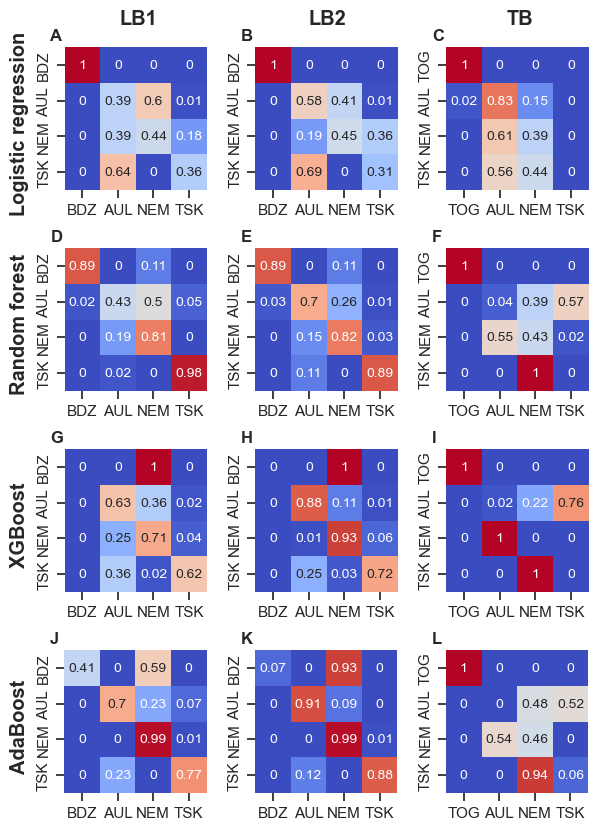

In [373]:
fig = plt.figure(layout="constrained", figsize=(6, 8))
subfigs = fig.subfigures(4, 1)

subfig_dict = dict(zip(algorithms, subfigs))
axes_dict = {}
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
letter_counter = 0

for algorithm, subfig in subfig_dict.items():
    axs = subfig.subplots(1, 3)
    axes_dict[algorithm] = axs
    for num, subset in enumerate(subsets):
        conf_mat = conf_mat_dict[algorithm][subset]['conf_mat'].round(2)
        labels = conf_mat_dict[algorithm][subset]['labels']
        sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, cbar=False, ax=axs[num], vmin=0, vmax=1, cmap='coolwarm', annot=True, square=True, annot_kws={'size':'small'})
        #axs[num].text(-0.1, 1, letters[letter_counter+num], size='medium', transform=axs[num].transAxes, ha='left', va='bottom')
        #title = "Subset " + subset.upper()
        # axs[num].set_title(letters[letter_counter+num], size='medium', weight='bold', loc='left')
        axs[num].annotate(letters[letter_counter+num], (-.1, 1.05), xycoords='axes fraction', size='medium', weight='bold')
    letter_counter += 3
    subfig.supylabel(titles[algorithm], weight='bold')

fig.text(x=0.190, y=1.0, s='LB1', size='large', weight='bold')
fig.text(x=0.505, y=1.0, s='LB2', size='large', weight='bold')
fig.text(x=0.835, y=1.0, s='TB', size='large', weight='bold')

In [374]:
fig.savefig('Plots/ConfusionMatricesHeatmaps.jpg', dpi=300, bbox_inches='tight')

## Boxplots

In [376]:
other_elems = ['V', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Ba', 'Hf', 'Th', 'U']
ree = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Y', 'Er', 'Tm', 'Yb', 'Lu']

In [377]:
ppm_long_other = ppm_long[ppm_long.Element.isin(other_elems)]
ppm_long_ree = ppm_long[ppm_long.Element.isin(ree)]

### Other elements

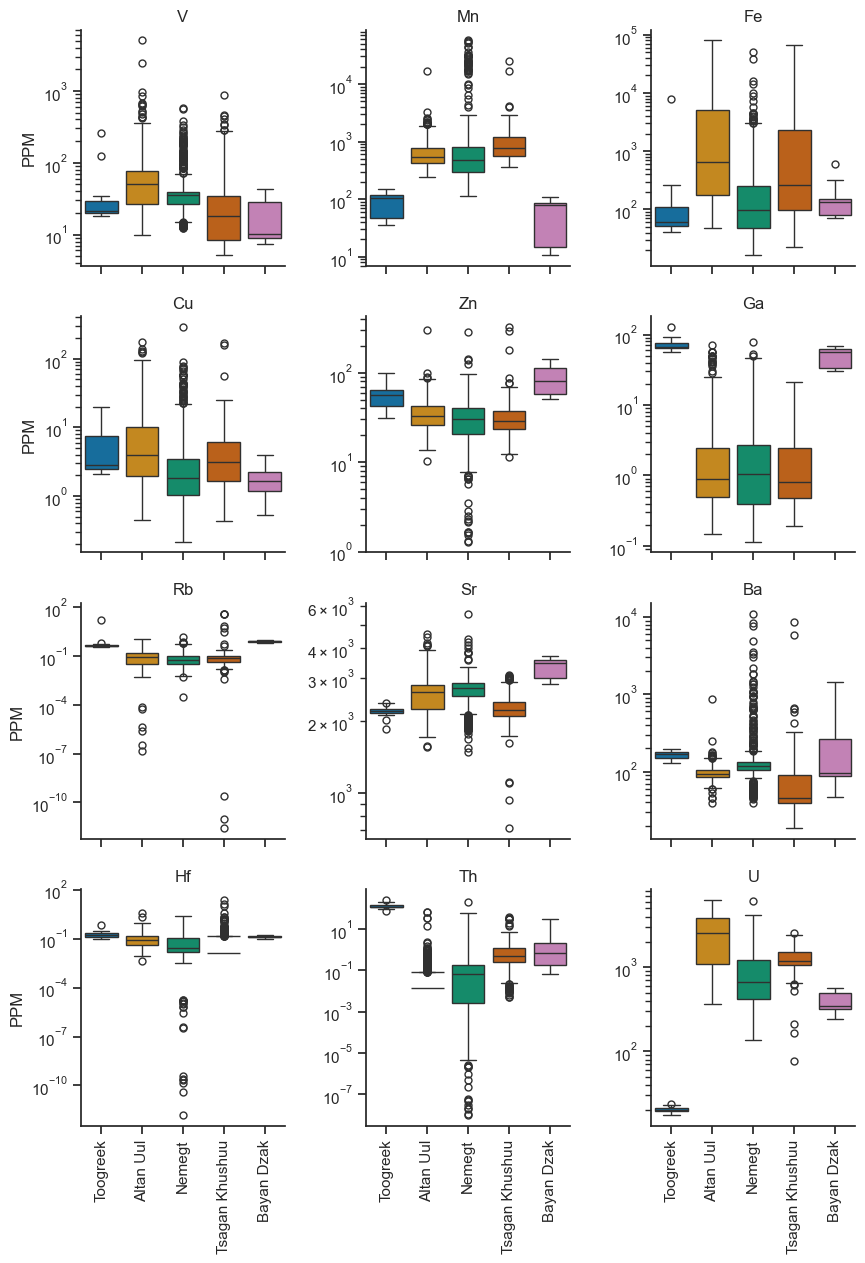

In [379]:
cp = sns.catplot(
    ppm_long_other, 
    x='Locality', 
    y='PPM', 
    col='Element', 
    col_wrap=3, 
    palette='colorblind', 
    log_scale=True, 
    hue='Locality',
    sharey=False,
    kind='box',
    height=3,
    aspect=1
)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in cp.axes.flat]
cp.set(xlabel=None)
cp.set_titles('{col_name}')

In [380]:
cp.savefig('Plots/boxplots - non-REEY.jpg', dpi=300)

### REEY

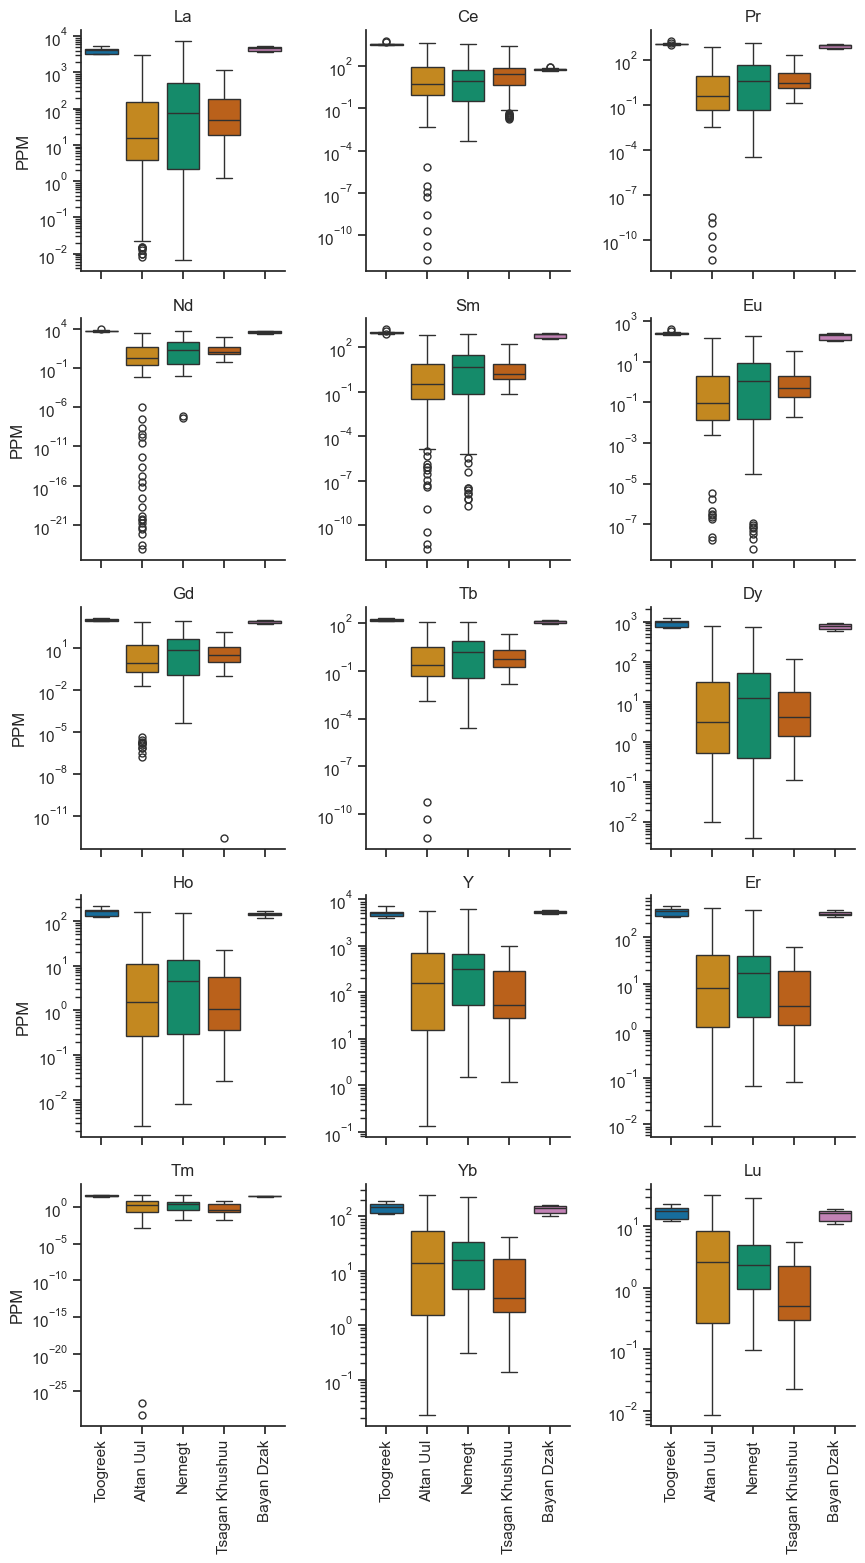

In [382]:
cp = sns.catplot(
    ppm_long_ree, 
    x='Locality', 
    y='PPM', 
    col='Element', 
    col_wrap=3, 
    palette='colorblind', 
    log_scale=True, 
    hue='Locality',
    sharey=False,
    kind='box',
    height=3,
    aspect=1,
    col_order = ree
)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in cp.axes.flat]
cp.set(xlabel=None)
cp.set_titles('{col_name}')

In [383]:
cp.savefig('Plots/boxplots - REEY.jpg', dpi=300)

###  Ba and Sr

In [385]:
basr = ppm.loc[:, ['Ba', 'Sr']].merge(spot_info, left_index=True, right_index=True)

In [386]:
basr_long = basr.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

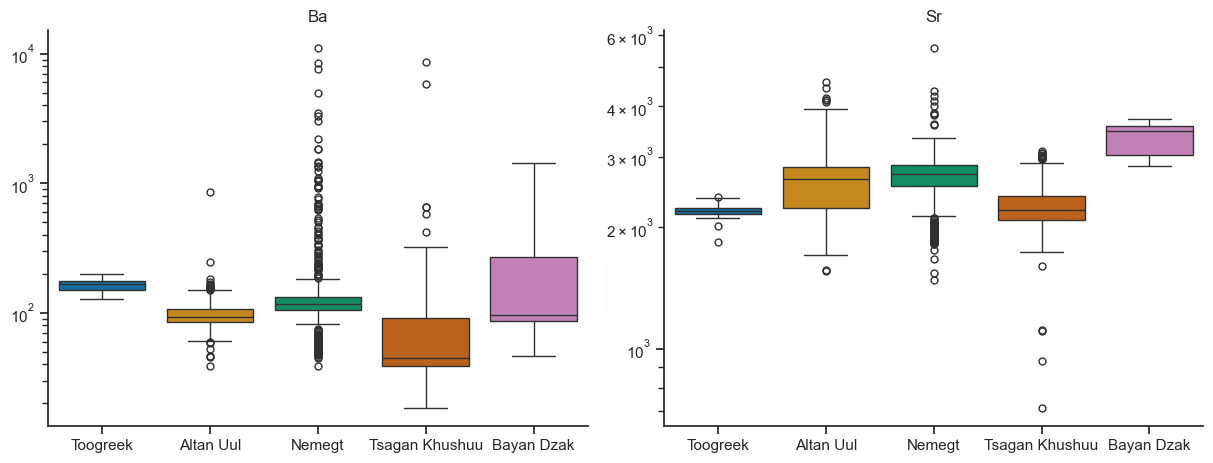

In [387]:
cp = sns.catplot(basr_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [388]:
cp.savefig('Plots/Sr and Ba contents.jpg', dpi=300)

[Text(0.5, 0, ''), Text(0, 0.5, 'Sr/Ba')]

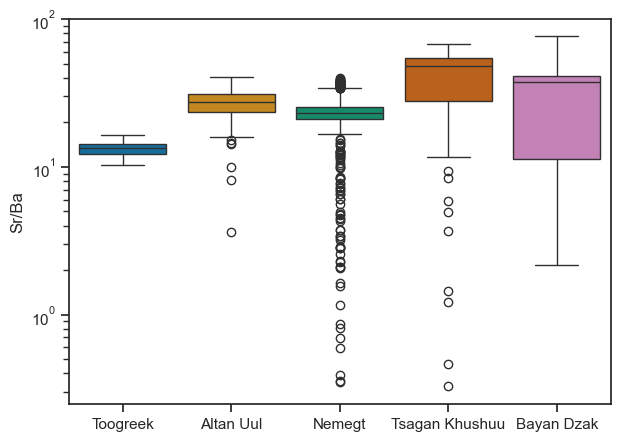

In [389]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=basr, x='Locality', y=basr.Sr/basr.Ba, hue='Locality', log_scale=True, ax=ax)
ax.set(xlabel='', ylabel='Sr/Ba')

In [390]:
fig.savefig('Plots/Sr-Ba ratio.jpg', dpi=300)

## HREE

In [392]:
hree = ppm.loc[:, ['Y', 'Tm', 'Yb', 'Ho']].merge(spot_info, left_index=True, right_index=True)

In [393]:
hree_long = hree.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

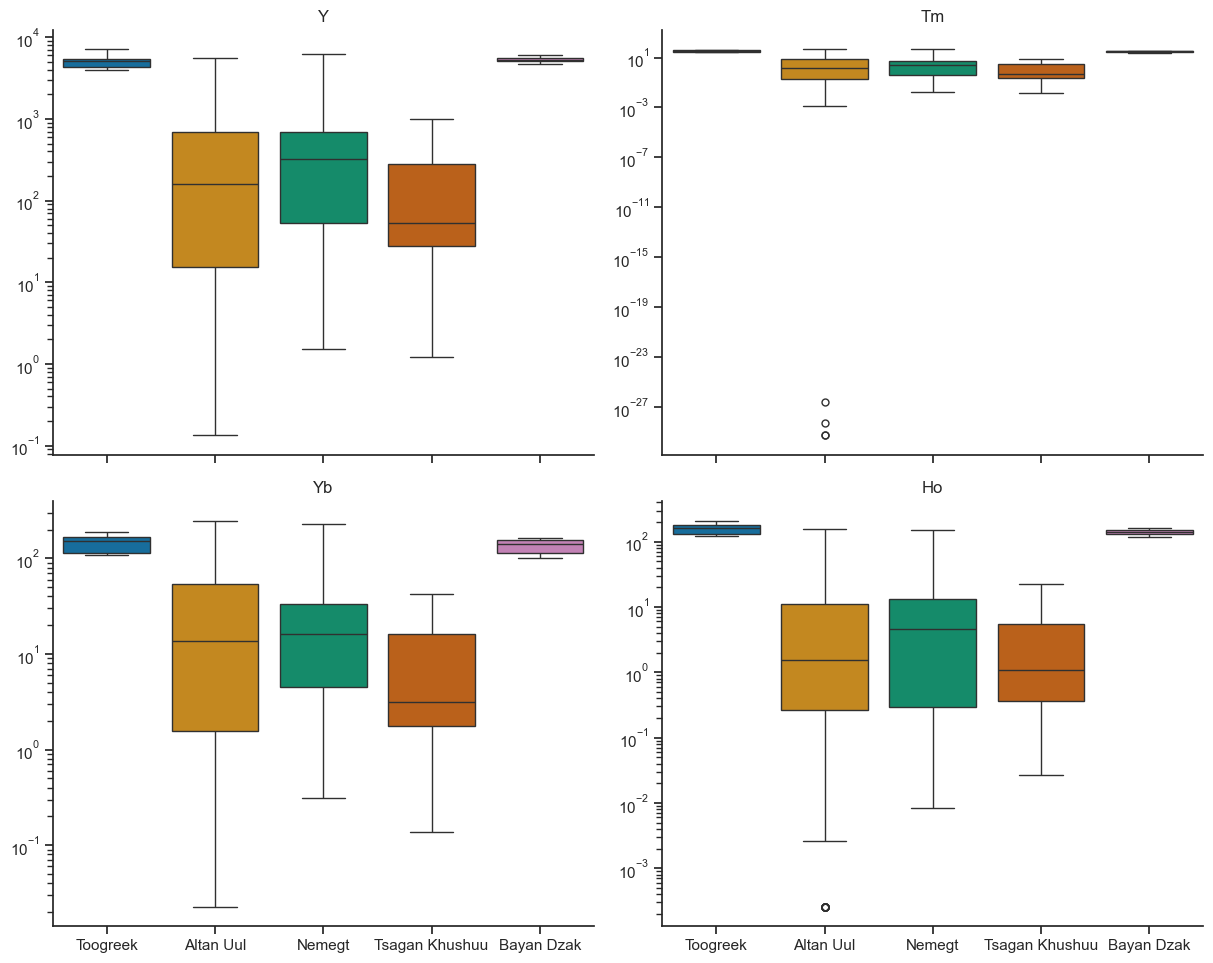

In [394]:
cp = sns.catplot(hree_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', col_wrap=2, sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [395]:
fig.savefig('Plots/HREE boxplots.jpg', dpi=300)

## Mn and Fe

In [397]:
metox = ppm.loc[:, ['Mn', 'Fe']].merge(spot_info, left_index=True, right_index=True)

In [398]:
metox_long = metox.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

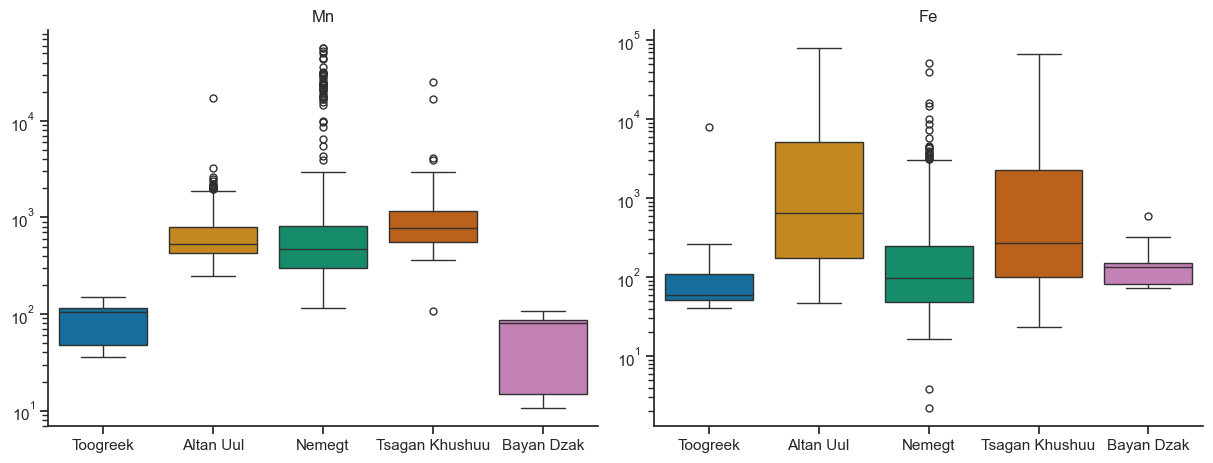

In [399]:
cp = sns.catplot(metox_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [400]:
fig.savefig('Plots/Fe and Mn boxplots.jpg', dpi=300)

[Text(0.5, 0, ''), Text(0, 0.5, 'Fe/Mn')]

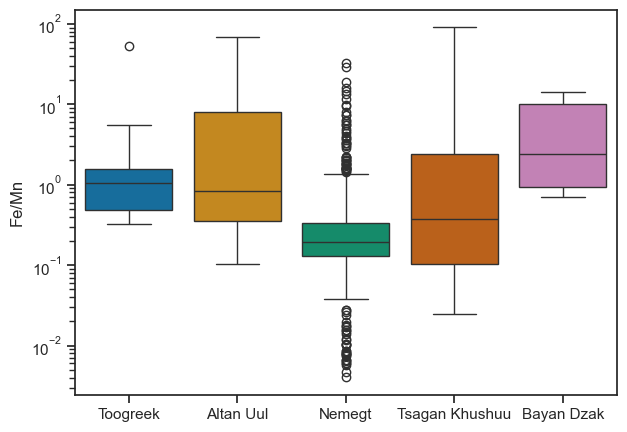

In [401]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=metox, x='Locality', y=metox.Fe/metox.Mn, hue='Locality', log_scale=True, ax=ax)
ax.set(xlabel='', ylabel='Fe/Mn')

In [402]:
fig.savefig('Plots/Mn-Fe ratio.jpg', dpi=300)

## U and Th

In [404]:
uth = ppm.loc[:, ['U', 'Th']].merge(spot_info, left_index=True, right_index=True)

In [405]:
uth_long = uth.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

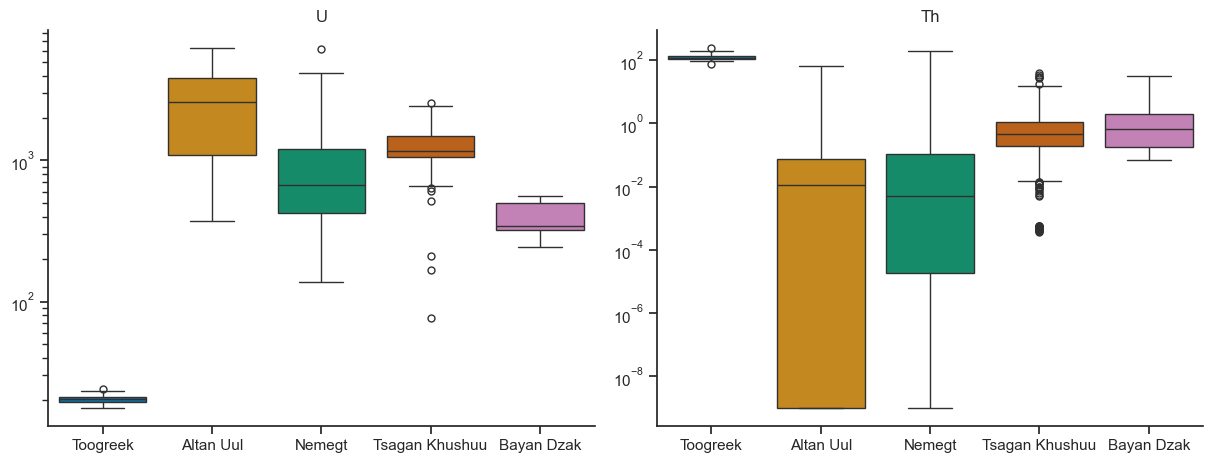

In [406]:
cp = sns.catplot(uth_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [407]:
fig.savefig('Plots/U and Th boxplots.jpg', dpi=300)

[Text(0.5, 0, ''), Text(0, 0.5, 'Th/U')]

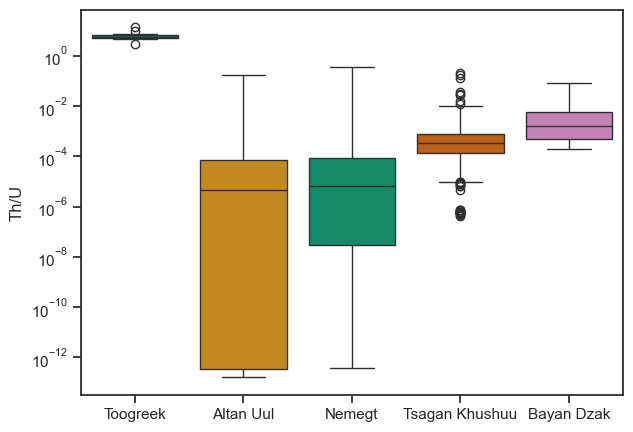

In [408]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=basr, x='Locality', y=uth.Th/uth.U, hue='Locality', log_scale=True, ax=ax)
ax.set(xlabel='', ylabel='Th/U')

In [409]:
fig.savefig('Plots/Th-U ratio.jpg', dpi=300)

In [410]:
selected_others = ppm.loc[:, ['Ba', 'Sr', 'Mn', 'Fe', 'U', 'Th']].merge(spot_info, left_index=True, right_index=True)

In [411]:
selected_hree = ppm.loc[:, ['Ho', 'Y', 'Tm', 'Yb']].merge(spot_info, left_index=True, right_index=True)

In [412]:
selected_others = selected_others.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

In [413]:
selected_hree = selected_hree.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

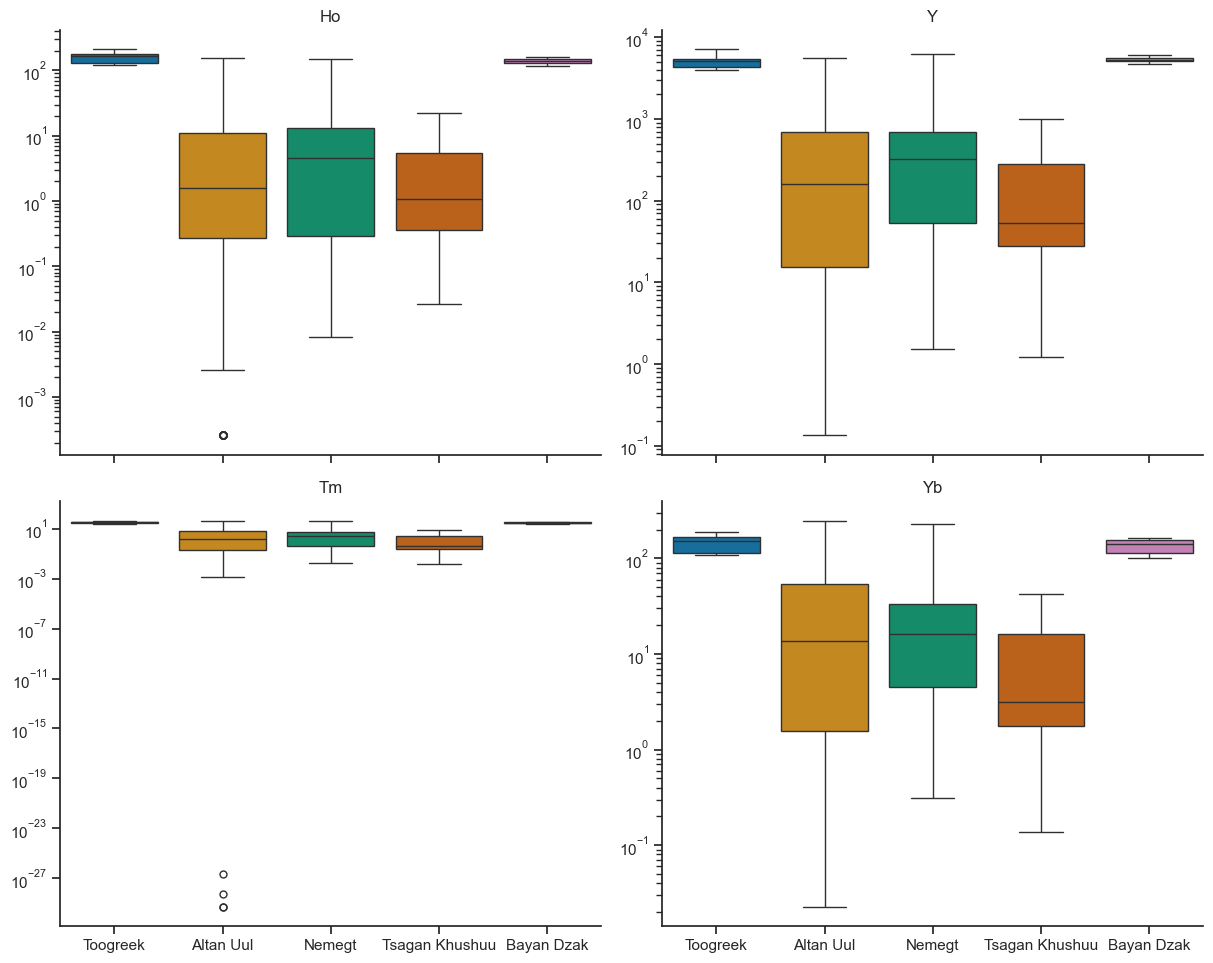

In [414]:
cp = sns.catplot(selected_hree, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', col_wrap=2, sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [415]:
cp.savefig('Plots/HREE boxplots.jpg', dpi=300)

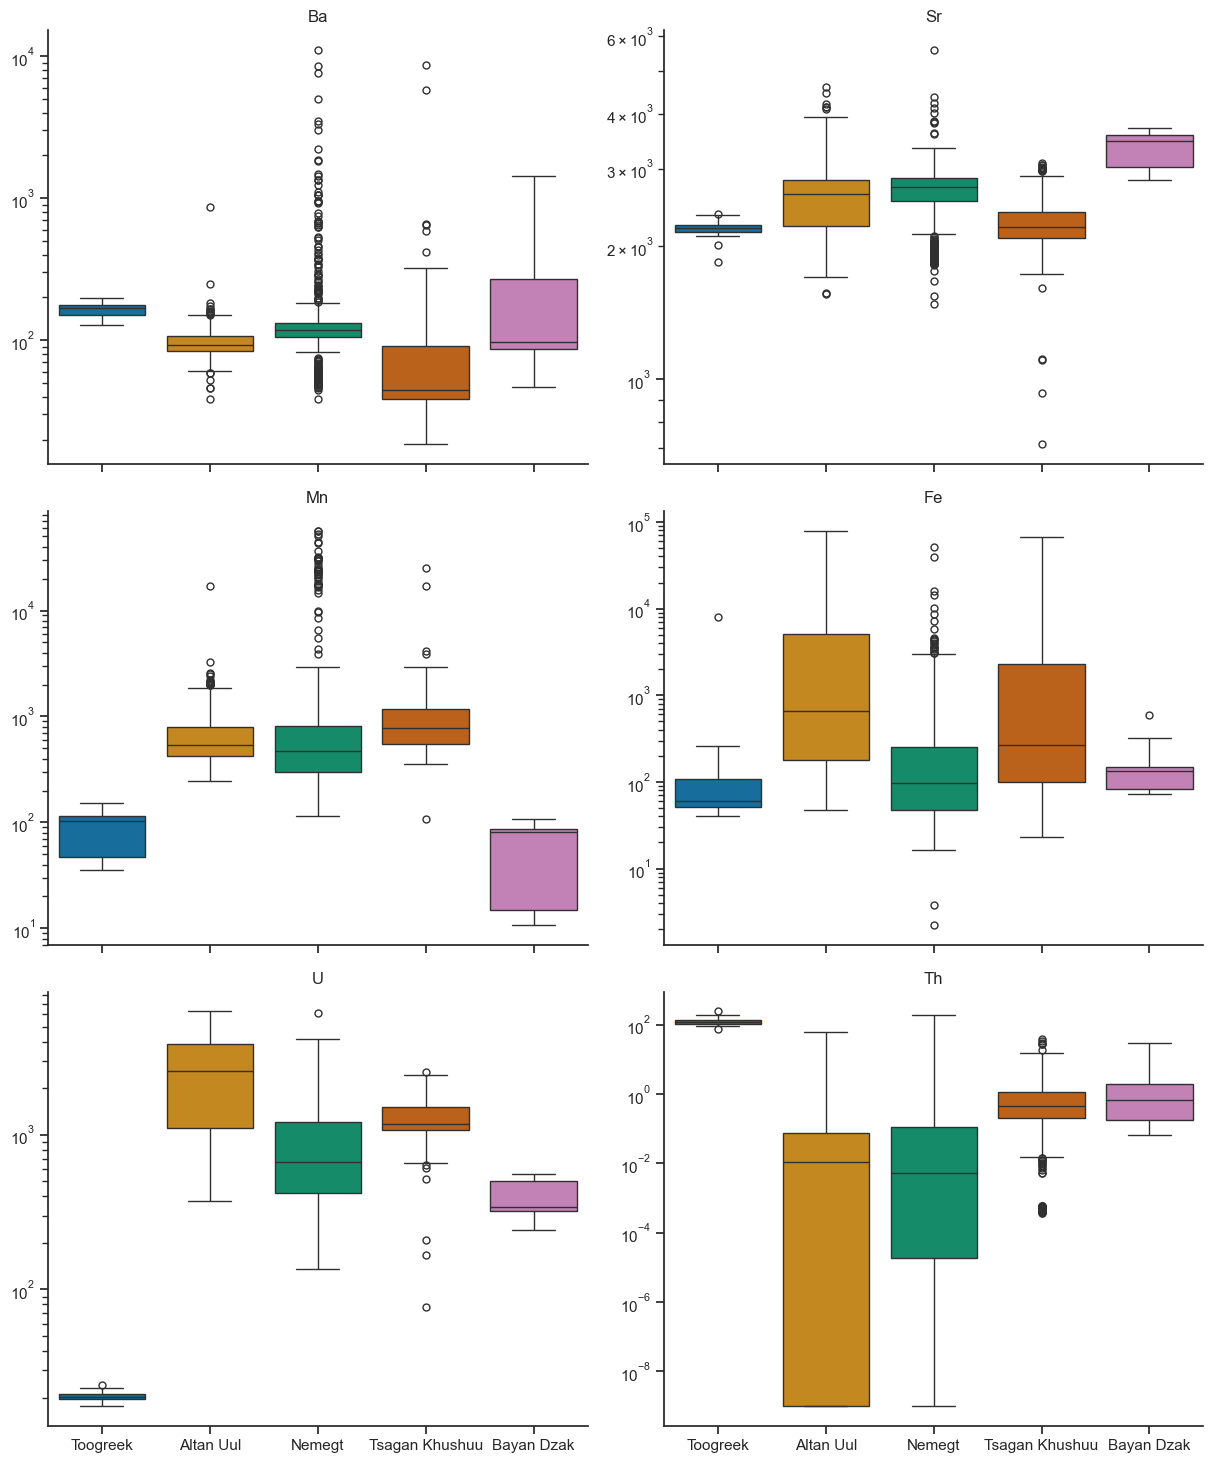

In [416]:
cp = sns.catplot(selected_others, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', col_wrap=2, sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [417]:
cp.savefig('Plots/Other elements boxplots.jpg', dpi=300)

In [418]:
ppm_fullframe = ppm.merge(spot_info, left_index=True, right_index=True)

In [419]:
ppmData = ppm_fullframe.reset_index()
ppmData['SampleLine'] = ppmData.SampleID + '-' + ppmData.Line

In [420]:
ppmData.columns

Index(['SampleID', 'Line', 'Spot', 'SpotID', 'Ca', 'V', 'Mn', 'Fe', 'Cu', 'Zn',
       'Ga', 'Rb', 'Sr', 'Y', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
       'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U', 'SpecimenID',
       'Genus', 'Locality', 'Bone', 'tissueType', 'mmDist', 'maxDist',
       'profilePerc', 'Other comm', 'SampleLine'],
      dtype='object')

In [421]:
ppmData = ppmData.loc[:, ['SampleID', 'Line', 'Spot', 'SpotID', 'SampleLine', 
                          'V', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y',
                          'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb',
                          'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U', 
                          'SpecimenID', 'Genus', 'Locality', 'Bone', 'tissueType', 
                          'mmDist', 'profilePerc']]

In [422]:
elements_analyzed = ['V', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U']

# Profiles of all elements

In [424]:
locs_order = 'Nemegt', 'Altan Uul', 'Tsagan Khushuu', 'Toogreek', 'Bayan Dzak'

In [425]:
locs_array = np.array([['Nemegt', 'Altan Uul', 'Tsagan Khushuu'], ['Toogreek', 'Bayan Dzak', None]])

Code below is to generate interactive plotly plot with profiles of all elements. The notebook takes a lot of time to process the code when it is active, so it remains inactive.

In [427]:
def count_fig_axes(plotly_fig, x=True, y=True):

    answer = {}
    
    if x:
        xaxes = 0
        for kword in plotly_fig.layout:
            if kword.startswith('xaxis'):
                xaxes += 1
        answer['x'] = xaxes
    if y:
        yaxes = 0
        for kword in plotly_fig.layout:
            if kword.startswith('yaxis'):
                yaxes += 1
        answer['y'] = yaxes
    return answer

#%% Element profiles

# create the figure with subplots for 5 localities (6th plot is empty)
plotly_fig = make_subplots(rows=2, cols=3, shared_xaxes='all', shared_yaxes='all', subplot_titles=locs_order, vertical_spacing=0.1, horizontal_spacing=0.05)

# code for the buttons of the element selection
steps_dict = {}
steps_back = 0
visibility = True

for element in elements_analyzed:
    ### iterate over elements
    ### from the table select only the columns with:
    ###  - an element of interest
    ###  - distance - that is, X-data
    ###  - sample and spot information (sample ID, spot no, profile, specimen)
    ###  - bone and locality
    frame = ppmData.loc[:, [element, 'SampleID', 'SpecimenID', 'mmDist', 'Bone', 'Locality', 'SampleLine', 'Spot']]
    frame.dropna(subset=element, inplace=True)
    step_vals = []

    for loc in locs_array.flatten():
        ### iteration over localitites
        
        if loc: # if locality is not NONE
            row, col = np.where(locs_array == loc)
            row, col = row[0] + 1, col[0] + 1
            
            frame_loc = frame[frame.Locality == loc]
            slines = frame_loc['SampleLine'].unique()

                        
            for sline in slines:
                ### iteration over sample-lines/profiles
                ### each profile is a trace added to the relevant plot
                frame_sline = frame_loc[frame_loc.SampleLine == sline]
 
                plotly_fig.add_trace(
                    go.Scatter(
                        visible=visibility,
                        mode='lines+markers',
                        x=frame_sline['mmDist'],
                        y=frame_sline[element],
                        text=[element] * len(frame_sline), # to ensure that each spot on the plot has `text` value equal to the name of an element
                        name=sline,
                        customdata=frame_sline[['SampleID', 'SampleLine', 'Spot', 'Bone', 'SpecimenID']]
                    ),
                    row=row,
                    col=col
                )
                step_vals.append(True)
        else: # if locality IS NONE
            continue
    
    # the code below is to ensure that the buttons related to the elements work properly and display selected element
    # the logic is to create a list of boolean values, where all values are FALSE,
    # except for the ones referring to the element selected from the button
    this_step = [False] * steps_back + step_vals + [False] * (1508 - (steps_back + len(step_vals))) # steps_back = elements_analyzed (that is - features) * no of samplelines (53)
    steps_dict[element] = this_step
    steps_back += len(step_vals)
    visibility = False



### code for selection of the elements
buttons = []

for elem, active_traces in steps_dict.items():
    button = dict(
        label=str(elem),
        method="restyle",
        args=["visible", active_traces]
    )
    buttons.append(button)

# count axes and set data for buttons switching between linear and logarithmic scale
ax_num = count_fig_axes(plotly_fig, x=False)['y'] - 1
args_lin = dict(zip([f'yaxis.type' if i == 0 else f'yaxis{i + 1}.type'for i in range(ax_num)], ['linear'] * ax_num))
args_log = dict(zip([f'yaxis.type' if i == 0 else f'yaxis{i + 1}.type'for i in range(ax_num)], ['log'] * ax_num))

### buttons to switch between linear and logarithmic scale
plotly_fig.update_layout(
    updatemenus=[
        dict(
            type='buttons', 
            buttons=buttons,
            showactive=True,
            x=-0.05,
            y=1,
            xanchor="center",
            yanchor="top",
            direction='down'),
        {
        'type' : 'buttons',
        'buttons' : [{
            'label' : 'Linear scale',
            'method' : 'relayout',
            'args' : [args_lin]
        },
        {
            'label' : 'Logscale',
            'method' : 'relayout',
            'args' : [args_log]
        }],
            'direction' : 'right',
            'x' : 0,
            'y' : 1.075,
            'xanchor' : 'left',
            'yanchor' : 'top'
    }
        
        ],
    width=1800,
    height=1200, 
    showlegend=False
)

                         
plotly_fig.update_traces(hovertemplate=
                         '<b>%{customdata[0]}</b><br>' +
                         '<i>%{customdata[1]}-%{customdata[2]}</i><br>' +
                         '<i>%{customdata[4]}</i><br>' +
                         'Bone: <b>%{customdata[3]}</b><br>' + 
                         'Distance: <b>%{x} mm</b><br>' + 
                         '%{text}: ' +'<b>%{y}</b>'+
                         "<extra></extra>")

plotly_fig.update_xaxes(range=(0, 40))
plotly_fig.update_yaxes(range=(-300, 5300))
plotly_fig.write_html('Plots\\Element profiles.html', default_width=2100, default_height=1400)

In [428]:
ppmData.columns

Index(['SampleID', 'Line', 'Spot', 'SpotID', 'SampleLine', 'V', 'Mn', 'Fe',
       'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm',
       'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U',
       'SpecimenID', 'Genus', 'Locality', 'Bone', 'tissueType', 'mmDist',
       'profilePerc'],
      dtype='object')

In [429]:
df = ppm.merge(spot_info, left_index=True, right_index=True)

In [430]:
df['Profile'] = df.index.get_level_values(0) + '-' + df.index.get_level_values(1)

In [431]:
ppmData.sort_values(['Locality', 'SampleID', 'Line', 'mmDist'], inplace=True)

In [432]:
all_profiles = PdfPages('All profiles.pdf')

for element in elements_analyzed:
    g = sns.relplot(df, 
                    x='mmDist',
                    y=element,
                    hue='Profile',
                    col='Locality',
                    col_wrap=3,
                    facet_kws=dict(sharex=False, sharey=False),
                    style='Profile').set(yscale='log', ylabel='Distance [mm]')
    
    sns.move_legend(g, loc='center left', ncols=3, title='Profile', bbox_to_anchor=(0.73, 0.28), fontsize='small')
    
    fig = g.figure
    fig.set_constrained_layout(True)
    
    all_profiles.savefig(fig)
    plt.close()
    
all_profiles.close()